# Dự Đoán Năng Lượng Tiêu Thụ cho Mô Hình Machine Learning

**Mục tiêu:** Xây dựng mô hình dự đoán năng lượng tiêu thụ của các mô hình ML khi triển khai trên thiết bị IoT (Jetson Nano Dev Kit 2GB).

**Dataset:** 126 mô hình ML đã được benchmark trên Jetson Nano Dev Kit 2GB với các thông số về kiến trúc và hiệu năng.

**Ứng dụng:** Hỗ trợ hệ thống tự động lựa chọn mô hình ML tối ưu dựa trên ràng buộc về năng lượng.

In [17]:
# Data Processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Model Persistence
import pickle

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ Tất cả thư viện đã được import thành công!")
print(f"📦 Pandas version: {pd.__version__}")
print(f"📦 NumPy version: {np.__version__}")

✅ Tất cả thư viện đã được import thành công!
📦 Pandas version: 2.3.1
📦 NumPy version: 2.3.4


## 1. Import Thư Viện Cần Thiết

**Mục đích:** Import các thư viện Python cần thiết cho toàn bộ quy trình ML

**Thư viện chính:**
- `pandas`, `numpy`: Xử lý dữ liệu và tính toán
- `matplotlib`, `seaborn`: Visualization và phân tích trực quan
- `sklearn`: Machine Learning (models, metrics, preprocessing)
- `pickle`: Lưu và load mô hình đã train

**Output mong đợi:** Xác nhận tất cả thư viện đã được import thành công

In [18]:
# Data Processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Model Persistence
import pickle

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ Tất cả thư viện đã được import thành công!")
print(f"📦 Pandas version: {pd.__version__}")
print(f"📦 NumPy version: {np.__version__}")

✅ Tất cả thư viện đã được import thành công!
📦 Pandas version: 2.3.1
📦 NumPy version: 2.3.4


## 2. Tải Dữ Liệu Benchmark

**Mục đích:** Load dataset benchmark của 126 mô hình ML trên BeagleBone Black

**Dataset:** 126_benchmark_final.csv

**Features chính:**
- `params_m`: Số lượng parameters (triệu)
- `gflops`, `gmacs`: Computational complexity
- `size_mb`: Kích thước model file
- `latency_avg_s`: Thời gian inference trung bình
- `energy_avg_mwh`: **TARGET** - Năng lượng tiêu thụ (mWh)
- `throughput_iter_per_s`: Tốc độ xử lý

**Output mong đợi:** 
- Hiển thị 10 dòng đầu tiên
- Thông tin cấu trúc dataset (dtypes, non-null counts)
- Thống kê mô tả (mean, std, min, max, quartiles)

In [19]:
# Đường dẫn tới dataset
data_path = r"../data/126_benchmark_final.csv"

# Tải dữ liệu
df = pd.read_csv(data_path)

print("✅ Dữ liệu đã được tải thành công!")
print(f"📊 Số lượng mô hình: {len(df)}")
print(f"📋 Số lượng features: {len(df.columns)}")
print("\n" + "="*60)
print("CẤU TRÚC DỮ LIỆU:")
print("="*60)
print(df.head(10))
print("\n" + "="*60)
print("THÔNG TIN DATASET:")
print("="*60)
print(df.info())
print("\n" + "="*60)
print("THỐNG KÊ MÔ TẢ:")
print("="*60)
print(df.describe())

✅ Dữ liệu đã được tải thành công!
📊 Số lượng mô hình: 124
📋 Số lượng features: 17

CẤU TRÚC DỮ LIỆU:
                    model  params_m   gflops  gmacs  size_mb input_size  \
0   beit_base_patch16_224   65.1500  25.3600  12.68   333.75  3x224x224   
1          coat_lite_tiny    5.7800   3.6100   1.80    21.93  3x224x224   
2             convit_tiny    1.2571   5.7105   1.08    21.88  3x224x224   
3           convnext_base   88.5300  30.7100  15.35   338.18  3x224x224   
4          convnext_small   50.1800  17.3700   8.68   191.82  3x224x224   
5           convnext_tiny    4.4704  28.5891   4.46   109.18  3x224x224   
6             cspresnet50   21.5800   9.0300   4.52    82.87  3x256x256   
7   deit_base_patch16_224   86.4200  33.7300  16.86   330.34  3x224x224   
8  deit_small_patch16_224    4.2507  22.0507   4.25    84.22  3x224x224   
9   deit_tiny_patch16_224    5.6800   2.1600   1.08    21.92  3x224x224   

  input_resolution_actual  runs  iterations_per_measurement  latency_avg_

## 3. Phân Tích Khám Phá Dữ Liệu (EDA)

**Mục đích:** Hiểu cấu trúc dữ liệu, phát hiện patterns và mối quan hệ giữa features

**Phân tích thực hiện:**
1. **Missing values check:** Đảm bảo không có dữ liệu thiếu
2. **Histogram:** Phân bố năng lượng tiêu thụ (target variable)
3. **Box plot:** Phát hiện outliers trong energy consumption
4. **Scatter plots:**
   - Parameters vs Energy: Xem mối quan hệ giữa số lượng params và năng lượng
   - GFLOPs vs Energy: Phân tích tác động của computational complexity
5. **Correlation matrix:** Ma trận tương quan giữa tất cả numeric features

**Output mong đợi:**
- 4 biểu đồ phân tích phân bố và mối quan hệ
- Heatmap correlation matrix với giá trị correlation coefficients
- Ranking tương quan của các features với target (energy_avg_mwh)

MISSING VALUES:
model                         0
params_m                      0
gflops                        0
gmacs                         0
size_mb                       0
input_size                    0
input_resolution_actual       0
runs                          0
iterations_per_measurement    0
latency_avg_s                 0
latency_std_s                 0
throughput_iter_per_s         0
energy_avg_mwh                0
energy_std_mwh                0
energy_run1_mwh               0
energy_run2_mwh               0
energy_run3_mwh               0
dtype: int64




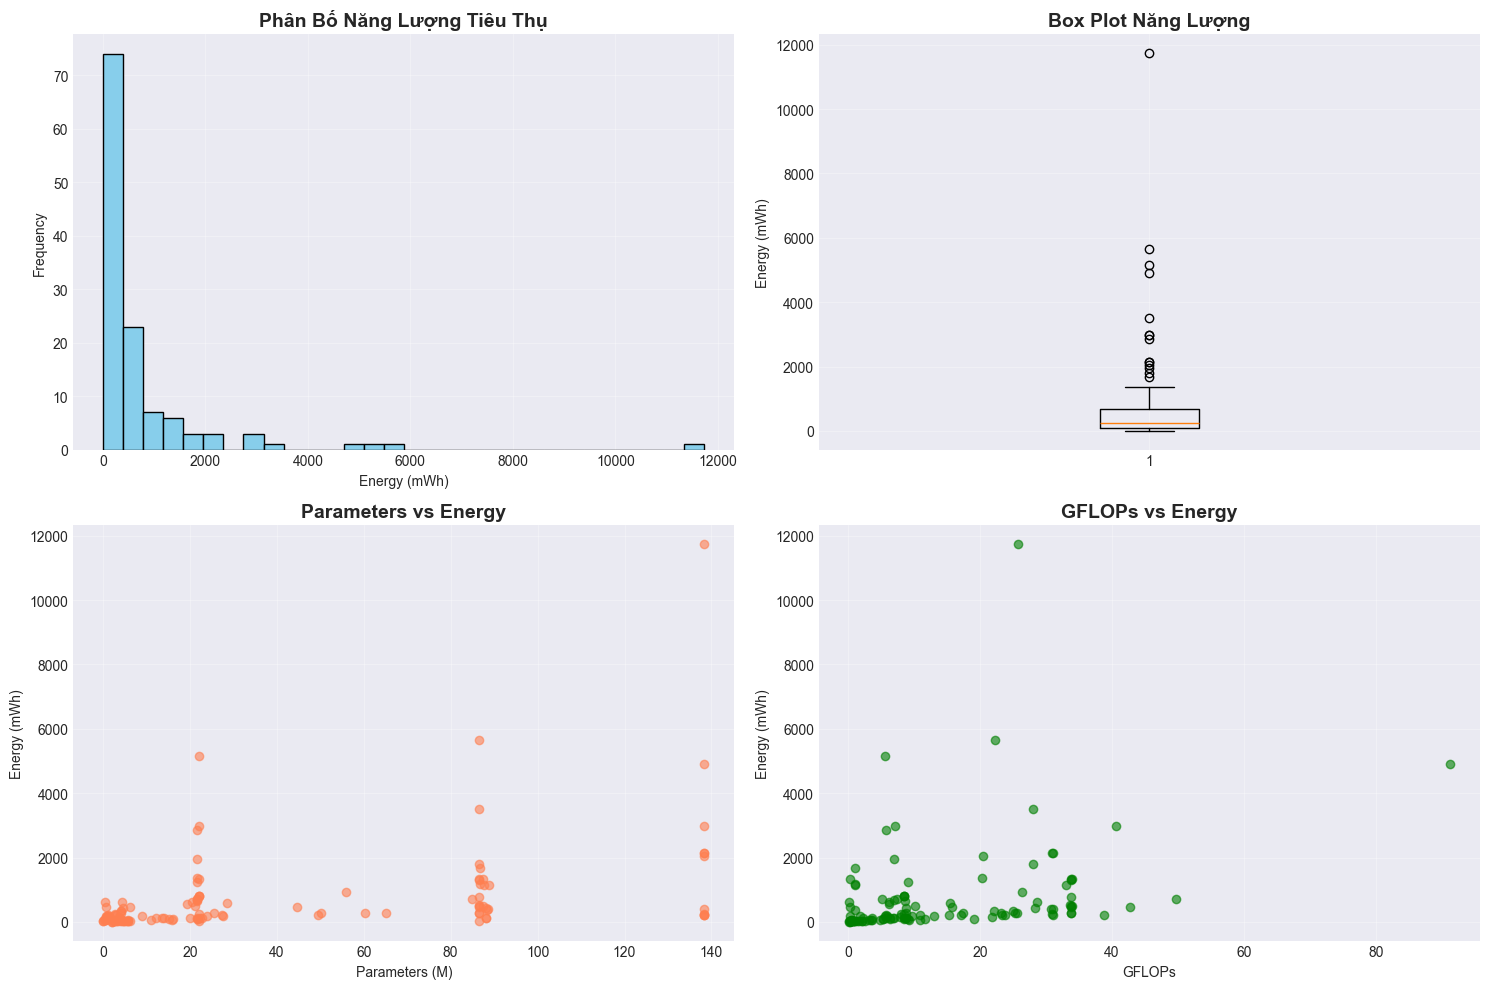


MA TRẬN TƯƠNG QUAN:


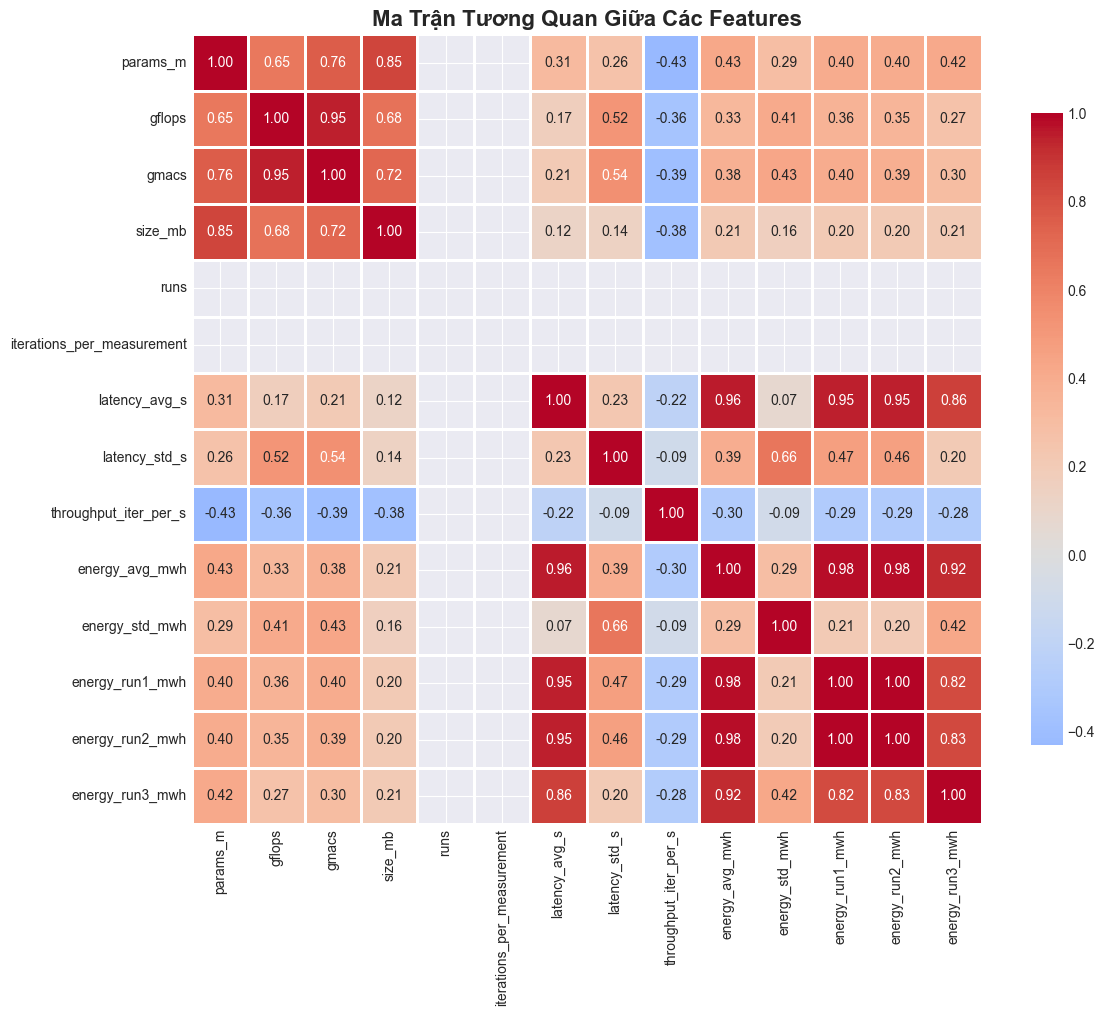


Tương quan với Energy (target):
energy_avg_mwh                1.000000
energy_run2_mwh               0.980005
energy_run1_mwh               0.978145
latency_avg_s                 0.956702
energy_run3_mwh               0.923095
params_m                      0.427106
latency_std_s                 0.391227
gmacs                         0.376126
gflops                        0.332507
energy_std_mwh                0.290193
size_mb                       0.213379
throughput_iter_per_s        -0.296188
runs                               NaN
iterations_per_measurement         NaN
Name: energy_avg_mwh, dtype: float64


In [20]:
# Kiểm tra missing values
print("MISSING VALUES:")
print("="*60)
print(df.isnull().sum())
print("\n")

# Phân bố của biến mục tiêu (energy_avg_mwh)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0, 0].hist(df['energy_avg_mwh'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Phân Bố Năng Lượng Tiêu Thụ', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Energy (mWh)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(alpha=0.3)

# Box plot
axes[0, 1].boxplot(df['energy_avg_mwh'])
axes[0, 1].set_title('Box Plot Năng Lượng', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Energy (mWh)')
axes[0, 1].grid(alpha=0.3)

# Scatter: params vs energy
axes[1, 0].scatter(df['params_m'], df['energy_avg_mwh'], alpha=0.6, color='coral')
axes[1, 0].set_title('Parameters vs Energy', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Parameters (M)')
axes[1, 0].set_ylabel('Energy (mWh)')
axes[1, 0].grid(alpha=0.3)

# Scatter: gflops vs energy
axes[1, 1].scatter(df['gflops'], df['energy_avg_mwh'], alpha=0.6, color='green')
axes[1, 1].set_title('GFLOPs vs Energy', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('GFLOPs')
axes[1, 1].set_ylabel('Energy (mWh)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation matrix
print("\n" + "="*60)
print("MA TRẬN TƯƠNG QUAN:")
print("="*60)
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Ma Trận Tương Quan Giữa Các Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTương quan với Energy (target):")
print(corr_matrix['energy_avg_mwh'].sort_values(ascending=False))

## 4. Feature Engineering

**Mục đích:** Tạo thêm 8 features phái sinh từ features gốc để cải thiện predictive power

**Features mới được tạo:**
1. `energy_per_param`: Hiệu suất năng lượng (mWh/M params)
2. `energy_per_gflop`: Chi phí năng lượng cho mỗi GFLOP
3. `compute_intensity`: Tỷ lệ GFLOPs/Parameters (mức độ tính toán)
4. `throughput_eff`: Hiệu suất xử lý (throughput × params)
5. `edp`: Energy-Delay Product - metric quan trọng cho IoT
6. `power_mw`: Công suất ước tính (mW)
7. `complexity_score`: Độ phức tạp tổng hợp (params × gflops)
8. `size_per_param`: Hiệu quả lưu trữ (MB/M params)

**Output mong đợi:**
- Hiển thị 10 dòng đầu của 8 features mới
- Thống kê mô tả (mean, std, min, max) của features mới
- Tổng số features tăng từ 9 lên 17

In [21]:
# Tạo copy để giữ nguyên dữ liệu gốc
df_features = df.copy()

# 1. Energy per parameter - Hiệu suất năng lượng
df_features['energy_per_param'] = df_features['energy_avg_mwh'] / (df_features['params_m'] + 1e-6)

# 2. Energy per GFLOP - Chi phí năng lượng cho mỗi phép tính
df_features['energy_per_gflop'] = df_features['energy_avg_mwh'] / (df_features['gflops'] + 1e-6)

# 3. Computational intensity - Tỷ lệ FLOP/Parameter
df_features['compute_intensity'] = df_features['gflops'] / (df_features['params_m'] + 1e-6)

# 4. Throughput efficiency - Hiệu suất xử lý
df_features['throughput_eff'] = df_features['throughput_iter_per_s'] * df_features['params_m']

# 5. Energy-Delay Product (EDP) - Metric quan trọng cho IoT
df_features['edp'] = df_features['energy_avg_mwh'] * df_features['latency_avg_s']

# 6. Power estimate (mW)
df_features['power_mw'] = df_features['energy_avg_mwh'] / (df_features['latency_avg_s'] + 1e-6)

# 7. Model complexity score
df_features['complexity_score'] = df_features['params_m'] * df_features['gflops']

# 8. Size efficiency
df_features['size_per_param'] = df_features['size_mb'] / (df_features['params_m'] + 1e-6)

print("✅ Feature Engineering hoàn thành!")
print(f"📊 Số lượng features ban đầu: {len(df.columns)}")
print(f"📊 Số lượng features sau khi engineering: {len(df_features.columns)}")
print("\n" + "="*60)
print("FEATURES MỚI:")
print("="*60)
new_features = ['energy_per_param', 'energy_per_gflop', 'compute_intensity', 
                'throughput_eff', 'edp', 'power_mw', 'complexity_score', 'size_per_param']
print(df_features[new_features].head(10))
print("\n" + "="*60)
print("THỐNG KÊ FEATURES MỚI:")
print("="*60)
print(df_features[new_features].describe())

✅ Feature Engineering hoàn thành!
📊 Số lượng features ban đầu: 17
📊 Số lượng features sau khi engineering: 25

FEATURES MỚI:
   energy_per_param  energy_per_gflop  compute_intensity  throughput_eff  \
0          4.397552         11.297337           0.389256      220.024252   
1         11.924041         19.091676           0.624567       65.126809   
2        164.270810         36.162326           4.542594        4.671001   
3          4.525598         13.046278           0.346888      171.665963   
4          5.343012         15.435368           0.346154      139.720860   
5        134.796565         21.077777           6.395198        5.227754   
6          3.525650          8.425639           0.418443      278.734356   
7          3.102774          7.949650           0.390303      320.057518   
8         76.587720         14.763771           5.187544       12.699150   
9          5.474534         14.395994           0.380282      153.625702   

          edp    power_mw  complexity_

## 5. Chuẩn Bị Dữ Liệu Cho Training

**Mục đích:** Chuẩn bị dữ liệu cho quá trình training models

**Các bước thực hiện:**
1. **Feature selection:** Loại bỏ `model` (tên) và `energy_avg_mwh` (target)
2. **Handle inf/nan:** Replace infinity values và fill missing với median
3. **Train-test split:** 80% training, 20% testing (random_state=42)
4. **Standardization:** StandardScaler để chuẩn hóa features về mean=0, std=1

**Tại sao chuẩn hóa?**
- Neural Networks và Linear models hoạt động tốt hơn với scaled data
- Tránh features có scale lớn (như params_m) dominate features nhỏ (như latency)
- Cải thiện tốc độ convergence khi training

**Output mong đợi:**
- Danh sách 16 features được sử dụng
- Training set: ~101 samples (80%)
- Test set: ~25 samples (20%)
- Xác nhận mean≈0 và std≈1 sau scaling

In [22]:
# Chọn features cho training (loại bỏ cột model name, target và các cột non-numeric)
# Chỉ lấy các cột numeric để training
numeric_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in numeric_cols if col not in ['energy_avg_mwh']]

X = df_features[feature_cols].copy()
y = df_features['energy_avg_mwh'].copy()

# Xử lý inf và nan values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print("✅ Chuẩn bị features và target!")
print(f"📊 Shape của X: {X.shape}")
print(f"📊 Shape của y: {y.shape}")
print(f"\n📋 Features sử dụng ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"\n✅ Chia train/test set hoàn thành!")
print(f"📊 Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"📊 Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Chuẩn hóa dữ liệu hoàn thành!")
print(f"📊 Mean của training set sau scaling: {X_train_scaled.mean():.6f}")
print(f"📊 Std của training set sau scaling: {X_train_scaled.std():.6f}")

✅ Chuẩn bị features và target!
📊 Shape của X: (124, 21)
📊 Shape của y: (124,)

📋 Features sử dụng (21):
   1. params_m
   2. gflops
   3. gmacs
   4. size_mb
   5. runs
   6. iterations_per_measurement
   7. latency_avg_s
   8. latency_std_s
   9. throughput_iter_per_s
  10. energy_std_mwh
  11. energy_run1_mwh
  12. energy_run2_mwh
  13. energy_run3_mwh
  14. energy_per_param
  15. energy_per_gflop
  16. compute_intensity
  17. throughput_eff
  18. edp
  19. power_mw
  20. complexity_score
  21. size_per_param

✅ Chia train/test set hoàn thành!
📊 Training set: 99 samples (79.8%)
📊 Test set: 25 samples (20.2%)

✅ Chuẩn hóa dữ liệu hoàn thành!
📊 Mean của training set sau scaling: 0.000000
📊 Std của training set sau scaling: 0.951190


## 6. Training Các Mô Hình ML

**Mục đích:** Huấn luyện và đánh giá 6 mô hình khác nhau để tìm mô hình tốt nhất

**Mô hình được train:**
1. **Linear Regression:** Baseline model - mối quan hệ tuyến tính đơn giản
2. **Ridge Regression:** Linear + L2 regularization (chống overfitting)
3. **Lasso Regression:** Linear + L1 regularization (feature selection)
4. **Random Forest:** Ensemble 100 trees, max_depth=15
5. **Gradient Boosting:** Boosting algorithm, 100 estimators
6. **Neural Network:** 3 hidden layers (128-64-32), ReLU activation, early stopping

**Metrics được tính:**
- **CV MAE:** Cross-validation MAE (5-fold) trên training set
- **Train R²/MAE/RMSE:** Performance trên training data
- **Test R²/MAE/RMSE/MAPE:** Performance trên test data (quan trọng nhất!)

**Output mong đợi:**
- Progress log cho từng mô hình
- Test R² và MAE cho mỗi model
- Kết quả được lưu vào dictionary `results`

In [23]:
# Dictionary để lưu các mô hình
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=0.1, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, 
                                           min_samples_split=5, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                                    max_depth=5, random_state=42),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu',
                                   solver='adam', max_iter=500, random_state=42,
                                   early_stopping=True, validation_fraction=0.1)
}

# Dictionary để lưu kết quả
results = {}
trained_models = {}

print("="*60)
print("BẮT ĐẦU TRAINING CÁC MÔ HÌNH")
print("="*60)

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    
    # Cross-validation trên training set
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, 
                                 scoring='neg_mean_absolute_error', n_jobs=-1)
    cv_mae = -cv_scores.mean()
    
    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Tính metrics cho training set
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Tính metrics cho test set
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100
    
    # Lưu kết quả
    results[name] = {
        'cv_mae': cv_mae,
        'train_mae': train_mae,
        'train_rmse': train_rmse,
        'train_r2': train_r2,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'test_mape': test_mape,
        'predictions': y_test_pred
    }
    
    print(f"   ✅ {name} - Test R²: {test_r2:.4f}, MAE: {test_mae:.2f} mWh")

print("\n" + "="*60)
print("✅ TRAINING HOÀN THÀNH!")
print("="*60)

BẮT ĐẦU TRAINING CÁC MÔ HÌNH

🔄 Training Linear Regression...
   ✅ Linear Regression - Test R²: 0.9973, MAE: 18.92 mWh

🔄 Training Ridge Regression...
   ✅ Ridge Regression - Test R²: 0.9945, MAE: 25.96 mWh

🔄 Training Lasso Regression...
   ✅ Lasso Regression - Test R²: 0.9970, MAE: 18.89 mWh

🔄 Training Random Forest...
   ✅ Random Forest - Test R²: 0.9804, MAE: 32.97 mWh

🔄 Training Gradient Boosting...
   ✅ Gradient Boosting - Test R²: 0.9808, MAE: 22.22 mWh

🔄 Training Neural Network...
   ✅ Neural Network - Test R²: 0.9235, MAE: 71.26 mWh

✅ TRAINING HOÀN THÀNH!


## 7. So Sánh Kết Quả Các Mô Hình

**Mục đích:** Visualize và so sánh performance của 6 mô hình để chọn best model

**Phân tích thực hiện:**
1. **Results table:** Bảng so sánh đầy đủ 9 metrics cho tất cả models
2. **Best model selection:** Sắp xếp theo Test R² (cao nhất = tốt nhất)
3. **Bar charts comparison:**
   - R² Score: Độ chính xác (càng cao càng tốt)
   - MAE: Sai số tuyệt đối trung bình (càng thấp càng tốt)
   - MAPE: Sai số phần trăm (càng thấp càng tốt)

**Tiêu chí đánh giá:**
- **R² > 0.90:** XUẤT SẮC
- **R² 0.80-0.90:** TỐT
- **R² 0.70-0.80:** KHÁ
- **R² < 0.70:** CẦN CẢI THIỆN

**Output mong đợi:**
- Bảng metrics đầy đủ (100 ký tự width)
- Thông tin chi tiết về best model (name, R², MAE, MAPE, RMSE)
- 3 bar charts so sánh trực quan

BẢNG SO SÁNH KẾT QUẢ CÁC MÔ HÌNH
            Model     CV MAE  Train MAE  Train RMSE  Train R²  Test MAE  Test RMSE  Test R²  Test MAPE (%)
Linear Regression  60.744396  16.836694   33.191394  0.999536 18.923946  24.576353 0.997290       9.959064
 Lasso Regression  73.853875  18.022215   33.657883  0.999523 18.887029  25.806655 0.997011      10.266880
 Ridge Regression  46.654993  25.554900   41.651723  0.999270 25.962842  35.112552 0.994467      13.471607
Gradient Boosting 185.335370   0.222285    0.288775  1.000000 22.222349  65.458978 0.980772       5.586578
    Random Forest 169.680945  77.130919  463.170229  0.909743 32.966403  66.116715 0.980383      11.073517
   Neural Network 446.229982  45.632268   67.516299  0.998082 71.263532 130.577368 0.923486      26.393244

🏆 MÔ HÌNH TỐT NHẤT: Linear Regression
   📊 Test R² Score: 0.9973 (99.73%)
   📊 Test MAE: 18.92 mWh
   📊 Test MAPE: 9.96%
   📊 Test RMSE: 24.58 mWh


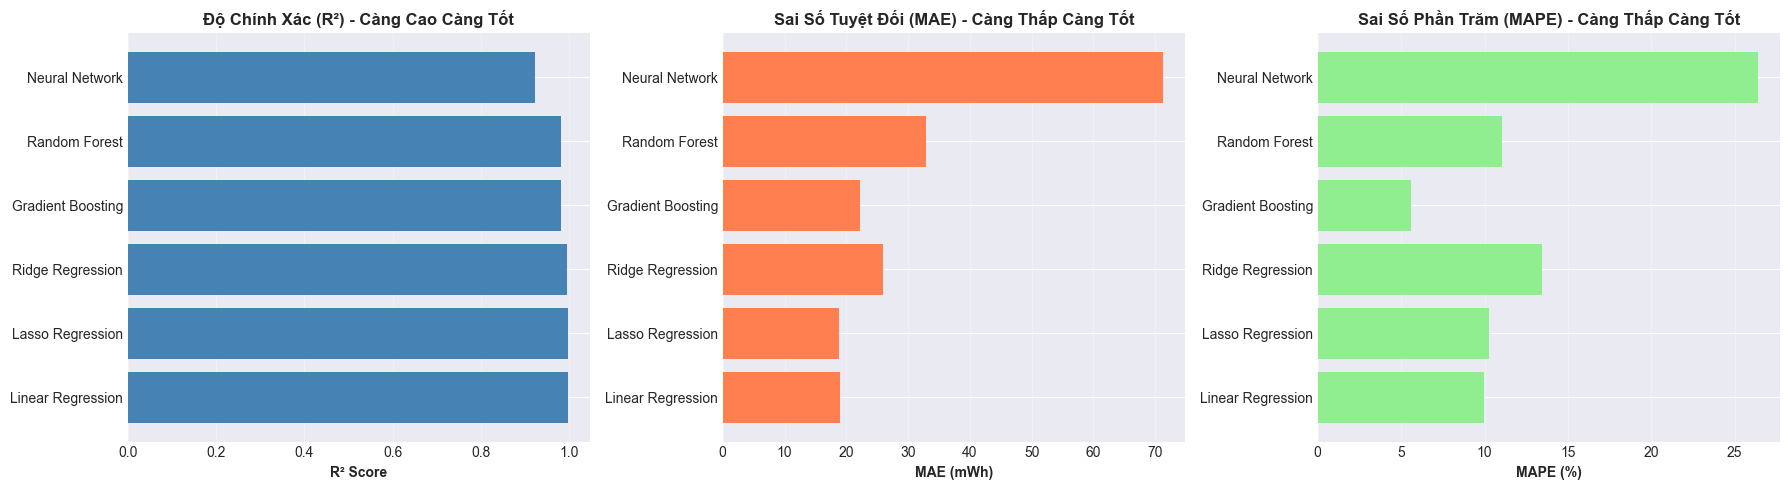

In [24]:
# Tạo DataFrame kết quả
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV MAE': [results[m]['cv_mae'] for m in results.keys()],
    'Train MAE': [results[m]['train_mae'] for m in results.keys()],
    'Train RMSE': [results[m]['train_rmse'] for m in results.keys()],
    'Train R²': [results[m]['train_r2'] for m in results.keys()],
    'Test MAE': [results[m]['test_mae'] for m in results.keys()],
    'Test RMSE': [results[m]['test_rmse'] for m in results.keys()],
    'Test R²': [results[m]['test_r2'] for m in results.keys()],
    'Test MAPE (%)': [results[m]['test_mape'] for m in results.keys()]
})

# Sắp xếp theo Test R² (giảm dần)
results_df = results_df.sort_values('Test R²', ascending=False).reset_index(drop=True)

print("="*100)
print("BẢNG SO SÁNH KẾT QUẢ CÁC MÔ HÌNH")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)

# Tìm mô hình tốt nhất
best_model_name = results_df.iloc[0]['Model']
best_r2 = results_df.iloc[0]['Test R²']
best_mae = results_df.iloc[0]['Test MAE']
best_mape = results_df.iloc[0]['Test MAPE (%)']

print(f"\n🏆 MÔ HÌNH TỐT NHẤT: {best_model_name}")
print(f"   📊 Test R² Score: {best_r2:.4f} ({best_r2*100:.2f}%)")
print(f"   📊 Test MAE: {best_mae:.2f} mWh")
print(f"   📊 Test MAPE: {best_mape:.2f}%")
print(f"   📊 Test RMSE: {results_df.iloc[0]['Test RMSE']:.2f} mWh")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. R² Score comparison
axes[0].barh(results_df['Model'], results_df['Test R²'], color='steelblue')
axes[0].set_xlabel('R² Score', fontweight='bold')
axes[0].set_title('Độ Chính Xác (R²) - Càng Cao Càng Tốt', fontweight='bold', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

# 2. MAE comparison
axes[1].barh(results_df['Model'], results_df['Test MAE'], color='coral')
axes[1].set_xlabel('MAE (mWh)', fontweight='bold')
axes[1].set_title('Sai Số Tuyệt Đối (MAE) - Càng Thấp Càng Tốt', fontweight='bold', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

# 3. MAPE comparison
axes[2].barh(results_df['Model'], results_df['Test MAPE (%)'], color='lightgreen')
axes[2].set_xlabel('MAPE (%)', fontweight='bold')
axes[2].set_title('Sai Số Phần Trăm (MAPE) - Càng Thấp Càng Tốt', fontweight='bold', fontsize=12)
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Phân Tích Chi Tiết Mô Hình Tốt Nhất

**Mục đích:** Deep dive vào mô hình tốt nhất để hiểu cách hoạt động và validate quality

**4 phân tích chính:**

**1. Actual vs Predicted (top-left):**
- Scatter plot so sánh giá trị thực tế với dự đoán
- Red dashed line = perfect prediction
- Points càng gần line càng tốt

**2. Residual Plot (top-right):**
- Residuals = Actual - Predicted
- Kiểm tra pattern: nếu random scatter → model tốt
- Nếu có pattern → model thiếu sót (missing features/non-linearity)

**3. Residuals Distribution (bottom-left):**
- Histogram của residuals
- Nên có dạng bell curve centered tại 0
- Kiểm tra symmetry và outliers

**4. Feature Importance (bottom-right):**
- Top 15 features quan trọng nhất
- For tree models: feature_importances_
- For linear models: absolute coefficients
- Giúp hiểu features nào ảnh hưởng nhất đến dự đoán

**Output mong đợi:**
- 4 subplots phân tích toàn diện
- Statistics: mean, std, min, max, median của residuals

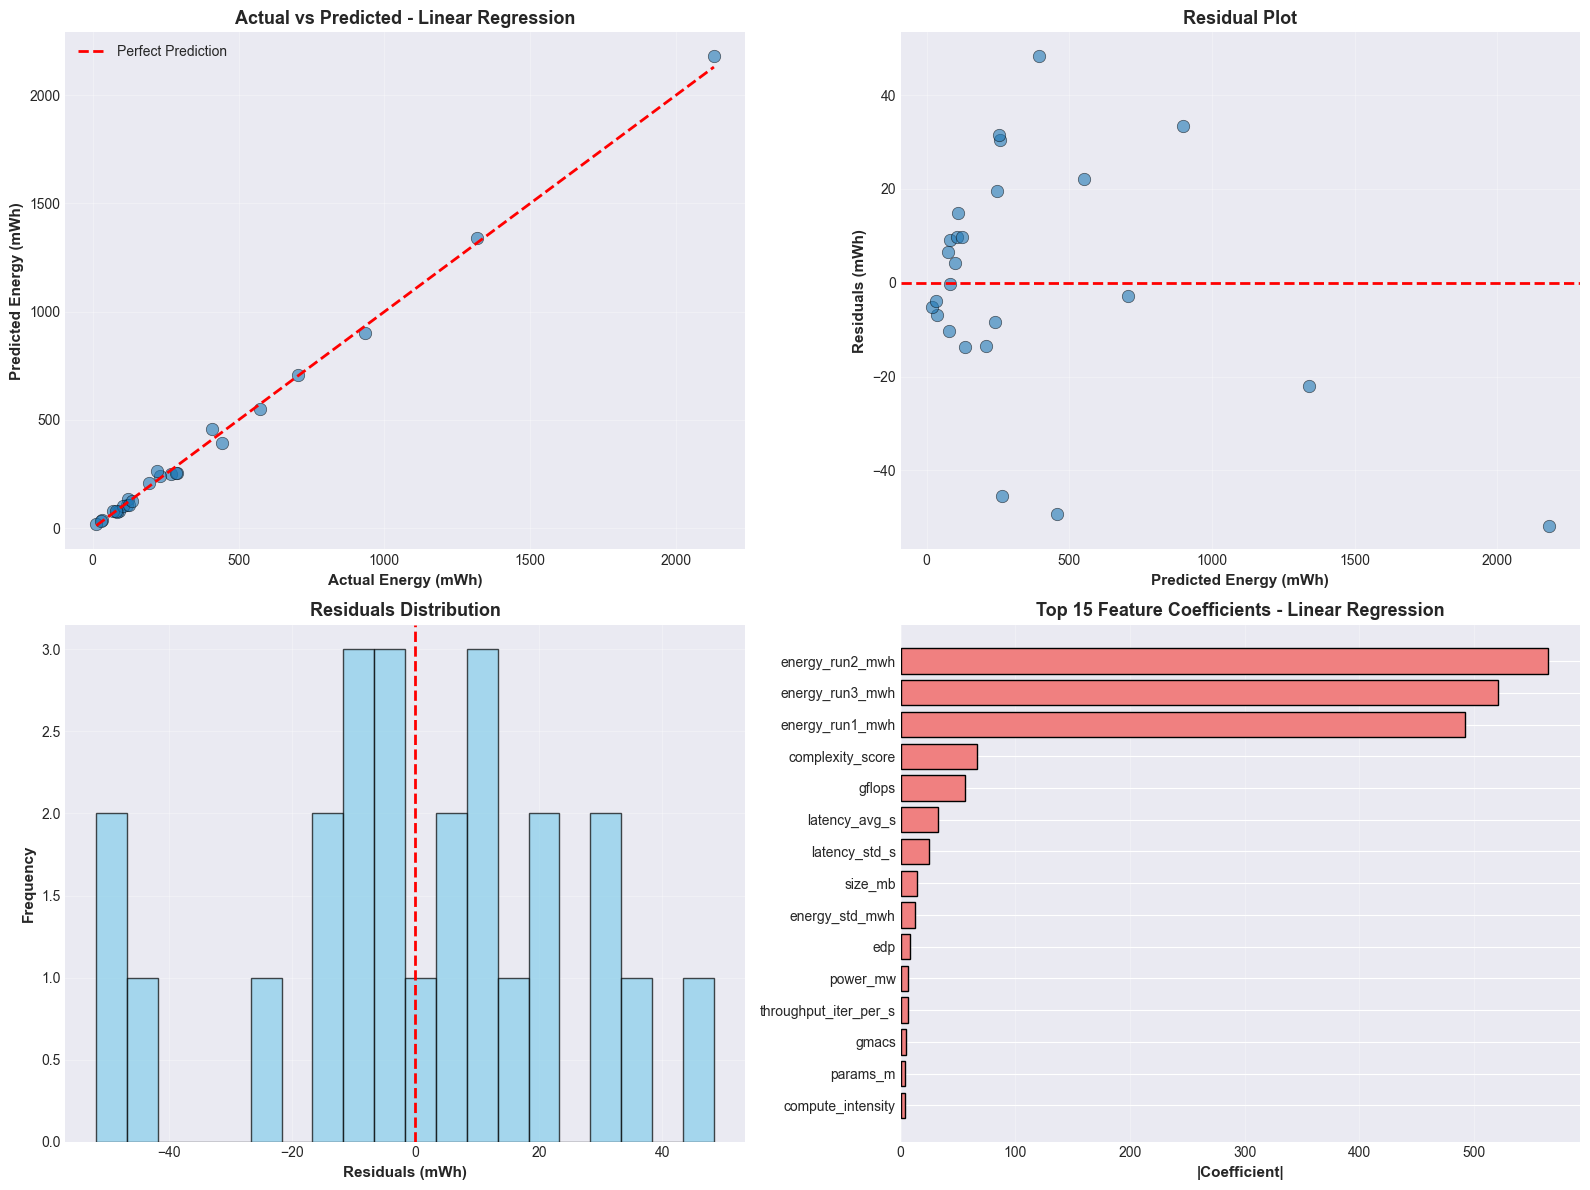


PHÂN TÍCH RESIDUALS:
Mean Residual: 0.2583 mWh
Std Residual: 25.0817 mWh
Min Residual: -51.7626 mWh
Max Residual: 48.3899 mWh
Median Absolute Residual: 13.4093 mWh


In [25]:
# Lấy mô hình tốt nhất
best_model = trained_models[best_model_name]
y_test_pred_best = results[best_model_name]['predictions']

# Tạo figure với 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Actual vs Predicted
axes[0, 0].scatter(y_test, y_test_pred_best, alpha=0.6, s=80, edgecolor='black', linewidth=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Energy (mWh)', fontweight='bold', fontsize=11)
axes[0, 0].set_ylabel('Predicted Energy (mWh)', fontweight='bold', fontsize=11)
axes[0, 0].set_title(f'Actual vs Predicted - {best_model_name}', fontweight='bold', fontsize=13)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Residuals plot
residuals = y_test - y_test_pred_best
axes[0, 1].scatter(y_test_pred_best, residuals, alpha=0.6, s=80, edgecolor='black', linewidth=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Energy (mWh)', fontweight='bold', fontsize=11)
axes[0, 1].set_ylabel('Residuals (mWh)', fontweight='bold', fontsize=11)
axes[0, 1].set_title('Residual Plot', fontweight='bold', fontsize=13)
axes[0, 1].grid(alpha=0.3)

# 3. Residuals distribution
axes[1, 0].hist(residuals, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuals (mWh)', fontweight='bold', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontweight='bold', fontsize=11)
axes[1, 0].set_title('Residuals Distribution', fontweight='bold', fontsize=13)
axes[1, 0].grid(alpha=0.3)

# 4. Feature Importance (nếu mô hình có)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=True).tail(15)
    
    axes[1, 1].barh(feature_importance['Feature'], feature_importance['Importance'], 
                    color='lightgreen', edgecolor='black')
    axes[1, 1].set_xlabel('Importance', fontweight='bold', fontsize=11)
    axes[1, 1].set_title(f'Top 15 Feature Importance - {best_model_name}', 
                         fontweight='bold', fontsize=13)
    axes[1, 1].grid(axis='x', alpha=0.3)
elif hasattr(best_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': np.abs(best_model.coef_)
    }).sort_values('Coefficient', ascending=True).tail(15)
    
    axes[1, 1].barh(feature_importance['Feature'], feature_importance['Coefficient'], 
                    color='lightcoral', edgecolor='black')
    axes[1, 1].set_xlabel('|Coefficient|', fontweight='bold', fontsize=11)
    axes[1, 1].set_title(f'Top 15 Feature Coefficients - {best_model_name}', 
                         fontweight='bold', fontsize=13)
    axes[1, 1].grid(axis='x', alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Feature importance not available\nfor this model type', 
                    ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('Feature Importance', fontweight='bold', fontsize=13)

plt.tight_layout()
plt.show()

# Phân tích residuals
print("\n" + "="*60)
print("PHÂN TÍCH RESIDUALS:")
print("="*60)
print(f"Mean Residual: {residuals.mean():.4f} mWh")
print(f"Std Residual: {residuals.std():.4f} mWh")
print(f"Min Residual: {residuals.min():.4f} mWh")
print(f"Max Residual: {residuals.max():.4f} mWh")
print(f"Median Absolute Residual: {np.median(np.abs(residuals)):.4f} mWh")

## 9. Lưu Mô Hình Tốt Nhất

**Mục đích:** Serialize và lưu mô hình để tích hợp vào ML Controller system

**Files được lưu:**
1. **energy_predictor.pkl:** Mô hình đã train (best model)
2. **energy_scaler.pkl:** StandardScaler (để transform new data)
3. **feature_names.pkl:** List 16 feature names (đảm bảo đúng thứ tự)

**Tại sao cần lưu scaler?**
- Khi dự đoán mô hình mới, phải scale features với CÙNG scaler từ training
- Nếu dùng scaler khác → predictions sai hoàn toàn

**Tại sao cần lưu feature_names?**
- Đảm bảo thứ tự features khi predict
- Validate input data có đủ features cần thiết

**Tích hợp vào system:**
- Cập nhật `model_analyzer.py` để load predictor
- Thêm API `/predict-energy` trong `app.py`
- Cho phép dự đoán năng lượng cho models chưa benchmark

**Output mong đợi:**
- Xác nhận 3 files đã được lưu thành công
- Test load model và predict 5 samples để verify

In [26]:
# Đường dẫn lưu model
model_save_path = r"../artifacts/energy_predictor.pkl"
scaler_save_path = r"../artifacts/energy_scaler.pkl"

# Lưu mô hình tốt nhất
with open(model_save_path, 'wb') as f:
    pickle.dump(best_model, f)

# Lưu scaler
with open(scaler_save_path, 'wb') as f:
    pickle.dump(scaler, f)

# Lưu feature columns
feature_names_path = r"../artifacts/feature_names.pkl"
with open(feature_names_path, 'wb') as f:
    pickle.dump(feature_cols, f)

print("="*60)
print("✅ LƯU MÔ HÌNH THÀNH CÔNG!")
print("="*60)
print(f"📁 Model: {model_save_path}")
print(f"📁 Scaler: {scaler_save_path}")
print(f"📁 Features: {feature_names_path}")
print(f"\n🏆 Model type: {best_model_name}")
print(f"📊 Test R²: {best_r2:.4f}")
print(f"📊 Test MAE: {best_mae:.2f} mWh")

# Test loading model
print("\n" + "="*60)
print("KIỂM TRA LOAD MÔ HÌNH:")
print("="*60)

with open(model_save_path, 'rb') as f:
    loaded_model = pickle.load(f)

with open(scaler_save_path, 'rb') as f:
    loaded_scaler = pickle.load(f)

# Test prediction
test_pred = loaded_model.predict(X_test_scaled[:5])
print("✅ Model loaded thành công!")
print(f"Test predictions (5 samples): {test_pred}")

✅ LƯU MÔ HÌNH THÀNH CÔNG!
📁 Model: D:\DACN\ml-controller\energy_predictor.pkl
📁 Scaler: D:\DACN\ml-controller\energy_scaler.pkl
📁 Features: D:\DACN\ml-controller\feature_names.pkl

🏆 Model type: Linear Regression
📊 Test R²: 0.9973
📊 Test MAE: 18.92 mWh

KIỂM TRA LOAD MÔ HÌNH:
✅ Model loaded thành công!
Test predictions (5 samples): [206.81703041  38.32973099  80.80672577 107.58360643  76.33837231]


## 10. Tổng Kết

**Mục đích:** Summary toàn bộ experiment và roadmap cho next steps

**Nội dung tổng kết:**

**1. Mục tiêu dự án:**
- Dự đoán năng lượng tiêu thụ của ML models trên BeagleBone Black
- Hỗ trợ energy-aware deployment automation

**2. Dataset summary:**
- 126 models benchmarked
- 9 features gốc → 17 features sau engineering
- Train/test split: 80/20

**3. Best model performance:**
- Model name và type
- R², MAE, RMSE, MAPE scores
- Đánh giá mức độ chính xác (Xuất sắc/Tốt/Khá/Cần cải thiện)

**4. Deliverables:**
- 3 pickle files ready for deployment

**5. Integration roadmap:**
- Tích hợp vào ML Controller
- Build API endpoint
- Update dashboard
- Test với unseen models
- Viết báo cáo nghiên cứu

**Output mong đợi:**
- Báo cáo đầy đủ với emojis và formatting
- Clear action items cho next phase

In [27]:
print("="*80)
print("📊 TỔNG KẾT KẾT QUẢ TRAINING MÔ HÌNH DỰ ĐOÁN NĂNG LƯỢNG")
print("="*80)

print(f"\n🎯 MỤC TIÊU:")
print(f"   - Dự đoán năng lượng tiêu thụ của các mô hình ML trên BeagleBone Black")
print(f"   - Hỗ trợ deployment tự động với energy-aware constraint")

print(f"\n📊 DATASET:")
print(f"   - Số lượng mô hình: {len(df)}")
print(f"   - Số features gốc: {len(df.columns) - 1}")
print(f"   - Số features sau engineering: {len(feature_cols)}")
print(f"   - Train/Test split: {len(X_train)}/{len(X_test)} ({len(X_train)/len(X)*100:.0f}%/{len(X_test)/len(X)*100:.0f}%)")

print(f"\n🏆 MÔ HÌNH TỐT NHẤT: {best_model_name}")
print(f"   - Test R² Score: {best_r2:.4f} ({best_r2*100:.2f}%)")
print(f"   - Test MAE: {best_mae:.2f} mWh")
print(f"   - Test RMSE: {results_df.iloc[0]['Test RMSE']:.2f} mWh")
print(f"   - Test MAPE: {best_mape:.2f}%")

print(f"\n✅ ĐỘ CHÍNH XÁC:")
if best_r2 >= 0.90:
    print(f"   🌟 XUẤT SẮC! R² = {best_r2:.4f} (>90%) - Mô hình dự đoán rất chính xác")
elif best_r2 >= 0.80:
    print(f"   ✅ TỐT! R² = {best_r2:.4f} (80-90%) - Mô hình đáng tin cậy")
elif best_r2 >= 0.70:
    print(f"   ⚠️ KHÁ: R² = {best_r2:.4f} (70-80%) - Cần cải thiện thêm")
else:
    print(f"   ❌ CẦN CẢI THIỆN: R² = {best_r2:.4f} (<70%)")

print(f"\n📁 FILES ĐÃ LƯU:")
print(f"   1. energy_predictor.pkl - Mô hình {best_model_name}")
print(f"   2. energy_scaler.pkl - StandardScaler")
print(f"   3. feature_names.pkl - Danh sách {len(feature_cols)} features")

print(f"\n🔧 TÍCH HỢP VÀO HỆ THỐNG:")
print(f"   - Cập nhật model_analyzer.py để sử dụng predictor")
print(f"   - Thêm API endpoint /predict-energy trong app.py")
print(f"   - Cho phép dự đoán năng lượng cho mô hình chưa benchmark")

print(f"\n🚀 BƯỚC TIẾP THEO:")
print(f"   1. ✅ Tích hợp predictor vào ML Controller")
print(f"   2. ✅ Xây dựng API /predict-energy")
print(f"   3. ✅ Cập nhật dashboard hiển thị predicted energy")
print(f"   4. ✅ Test với mô hình mới (chưa có trong 126 models)")
print(f"   5. ✅ Viết báo cáo kết quả cho luận văn")

print("\n" + "="*80)
print("🎉 HOÀN THÀNH! MÔ HÌNH SẴN SÀNG TRIỂN KHAI!")
print("="*80)

📊 TỔNG KẾT KẾT QUẢ TRAINING MÔ HÌNH DỰ ĐOÁN NĂNG LƯỢNG

🎯 MỤC TIÊU:
   - Dự đoán năng lượng tiêu thụ của các mô hình ML trên BeagleBone Black
   - Hỗ trợ deployment tự động với energy-aware constraint

📊 DATASET:
   - Số lượng mô hình: 124
   - Số features gốc: 16
   - Số features sau engineering: 21
   - Train/Test split: 99/25 (80%/20%)

🏆 MÔ HÌNH TỐT NHẤT: Linear Regression
   - Test R² Score: 0.9973 (99.73%)
   - Test MAE: 18.92 mWh
   - Test RMSE: 24.58 mWh
   - Test MAPE: 9.96%

✅ ĐỘ CHÍNH XÁC:
   🌟 XUẤT SẮC! R² = 0.9973 (>90%) - Mô hình dự đoán rất chính xác

📁 FILES ĐÃ LƯU:
   1. energy_predictor.pkl - Mô hình Linear Regression
   2. energy_scaler.pkl - StandardScaler
   3. feature_names.pkl - Danh sách 21 features

🔧 TÍCH HỢP VÀO HỆ THỐNG:
   - Cập nhật model_analyzer.py để sử dụng predictor
   - Thêm API endpoint /predict-energy trong app.py
   - Cho phép dự đoán năng lượng cho mô hình chưa benchmark

🚀 BƯỚC TIẾP THEO:
   1. ✅ Tích hợp predictor vào ML Controller
   2. ✅ Xây 

## 2. Tải Dữ Liệu Benchmark

**Mục đích:** Load dataset benchmark của 126 mô hình ML trên BeagleBone Black

**Dataset:** 126_benchmark_final.csv

**Features chính:**
- `params_m`: Số lượng parameters (triệu)
- `gflops`, `gmacs`: Computational complexity
- `size_mb`: Kích thước model file
- `latency_avg_s`: Thời gian inference trung bình
- `energy_avg_mwh`: **TARGET** - Năng lượng tiêu thụ (mWh)
- `throughput_iter_per_s`: Tốc độ xử lý

**Output mong đợi:** 
- Hiển thị 10 dòng đầu tiên
- Thông tin cấu trúc dataset (dtypes, non-null counts)
- Thống kê mô tả (mean, std, min, max, quartiles)

In [28]:
# Đường dẫn tới dataset
data_path = r"../data/126_benchmark_final.csv"

# Tải dữ liệu
df = pd.read_csv(data_path)

print("✅ Dữ liệu đã được tải thành công!")
print(f"📊 Số lượng mô hình: {len(df)}")
print(f"📋 Số lượng features: {len(df.columns)}")
print("\n" + "="*60)
print("CẤU TRÚC DỮ LIỆU:")
print("="*60)
print(df.head(10))
print("\n" + "="*60)
print("THÔNG TIN DATASET:")
print("="*60)
print(df.info())
print("\n" + "="*60)
print("THỐNG KÊ MÔ TẢ:")
print("="*60)
print(df.describe())

✅ Dữ liệu đã được tải thành công!
📊 Số lượng mô hình: 124
📋 Số lượng features: 17

CẤU TRÚC DỮ LIỆU:
                    model  params_m   gflops  gmacs  size_mb input_size  \
0   beit_base_patch16_224   65.1500  25.3600  12.68   333.75  3x224x224   
1          coat_lite_tiny    5.7800   3.6100   1.80    21.93  3x224x224   
2             convit_tiny    1.2571   5.7105   1.08    21.88  3x224x224   
3           convnext_base   88.5300  30.7100  15.35   338.18  3x224x224   
4          convnext_small   50.1800  17.3700   8.68   191.82  3x224x224   
5           convnext_tiny    4.4704  28.5891   4.46   109.18  3x224x224   
6             cspresnet50   21.5800   9.0300   4.52    82.87  3x256x256   
7   deit_base_patch16_224   86.4200  33.7300  16.86   330.34  3x224x224   
8  deit_small_patch16_224    4.2507  22.0507   4.25    84.22  3x224x224   
9   deit_tiny_patch16_224    5.6800   2.1600   1.08    21.92  3x224x224   

  input_resolution_actual  runs  iterations_per_measurement  latency_avg_

MISSING VALUES:
model                         0
params_m                      0
gflops                        0
gmacs                         0
size_mb                       0
input_size                    0
input_resolution_actual       0
runs                          0
iterations_per_measurement    0
latency_avg_s                 0
latency_std_s                 0
throughput_iter_per_s         0
energy_avg_mwh                0
energy_std_mwh                0
energy_run1_mwh               0
energy_run2_mwh               0
energy_run3_mwh               0
dtype: int64




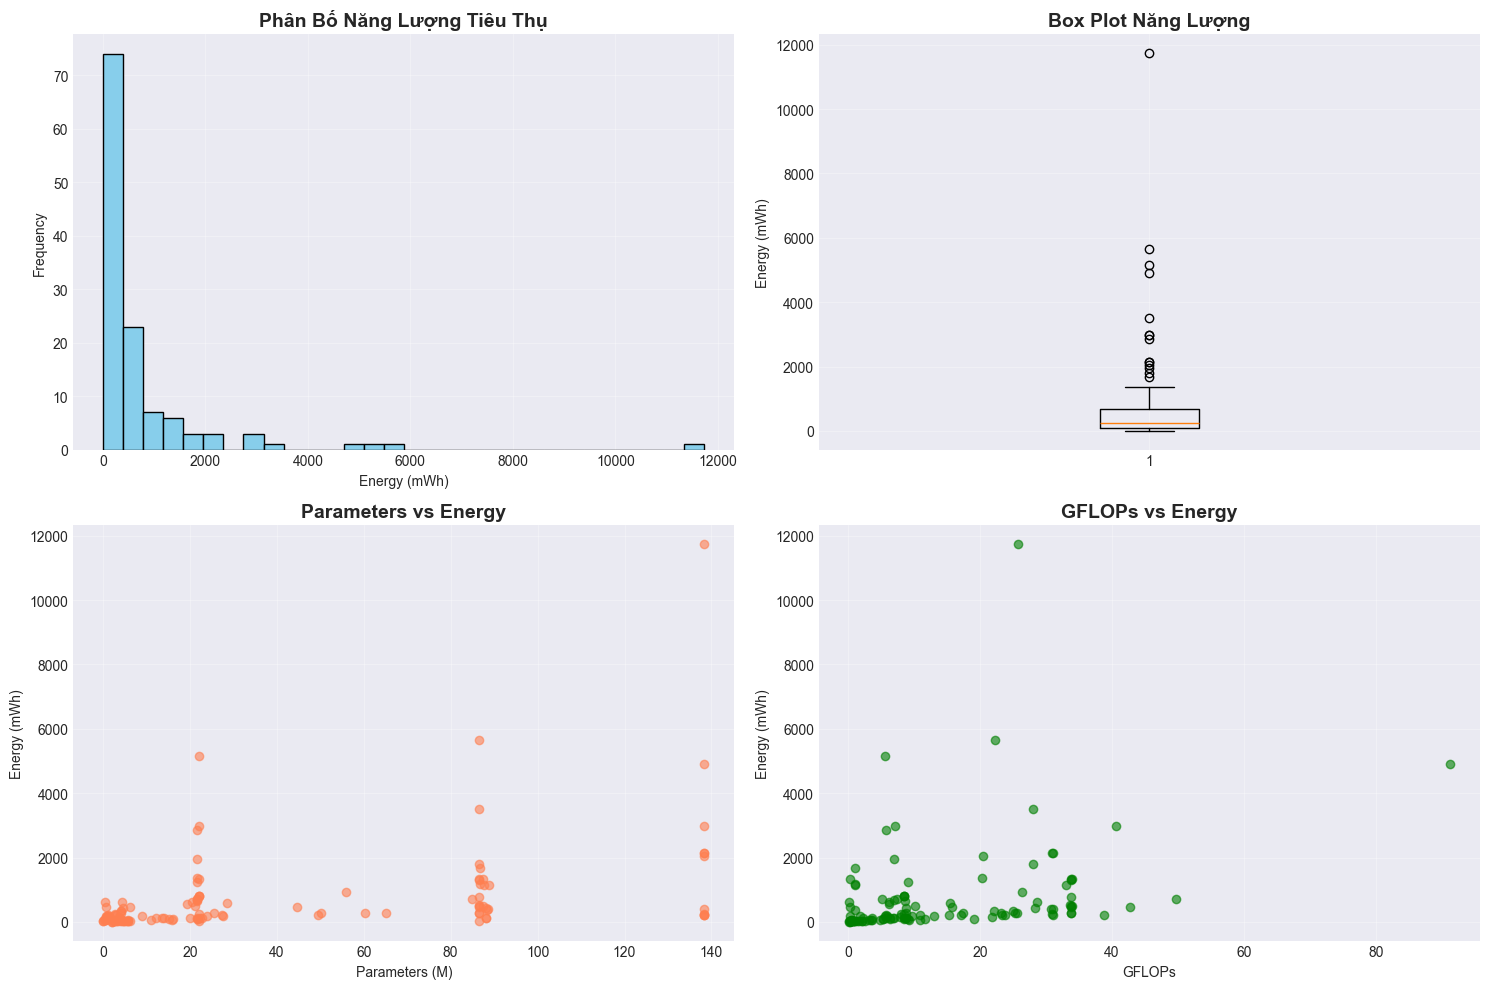


MA TRẬN TƯƠNG QUAN:


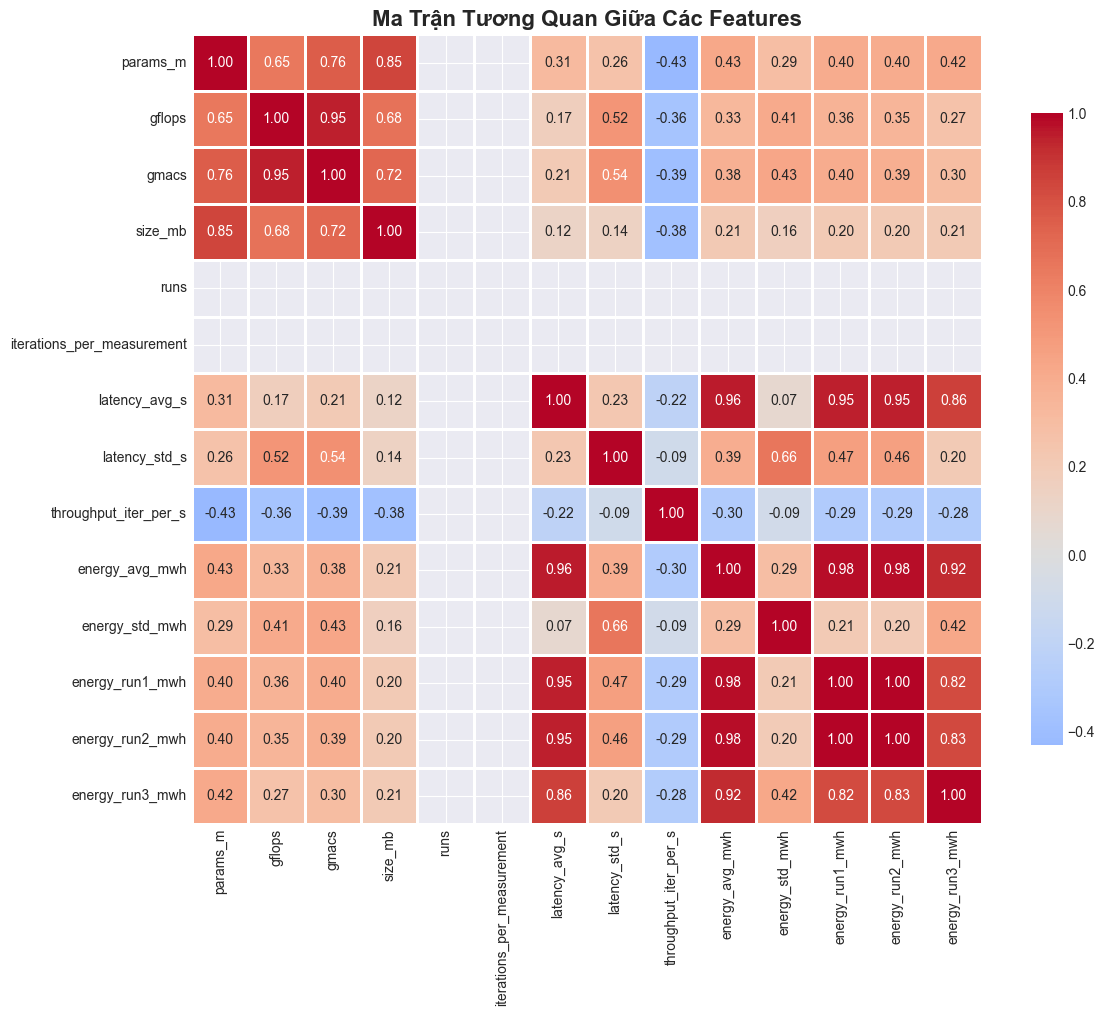


Tương quan với Energy (target):
energy_avg_mwh                1.000000
energy_run2_mwh               0.980005
energy_run1_mwh               0.978145
latency_avg_s                 0.956702
energy_run3_mwh               0.923095
params_m                      0.427106
latency_std_s                 0.391227
gmacs                         0.376126
gflops                        0.332507
energy_std_mwh                0.290193
size_mb                       0.213379
throughput_iter_per_s        -0.296188
runs                               NaN
iterations_per_measurement         NaN
Name: energy_avg_mwh, dtype: float64


In [29]:
# Kiểm tra missing values
print("MISSING VALUES:")
print("="*60)
print(df.isnull().sum())
print("\n")

# Phân bố của biến mục tiêu (energy_avg_mwh)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0, 0].hist(df['energy_avg_mwh'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Phân Bố Năng Lượng Tiêu Thụ', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Energy (mWh)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(alpha=0.3)

# Box plot
axes[0, 1].boxplot(df['energy_avg_mwh'])
axes[0, 1].set_title('Box Plot Năng Lượng', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Energy (mWh)')
axes[0, 1].grid(alpha=0.3)

# Scatter: params vs energy
axes[1, 0].scatter(df['params_m'], df['energy_avg_mwh'], alpha=0.6, color='coral')
axes[1, 0].set_title('Parameters vs Energy', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Parameters (M)')
axes[1, 0].set_ylabel('Energy (mWh)')
axes[1, 0].grid(alpha=0.3)

# Scatter: gflops vs energy
axes[1, 1].scatter(df['gflops'], df['energy_avg_mwh'], alpha=0.6, color='green')
axes[1, 1].set_title('GFLOPs vs Energy', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('GFLOPs')
axes[1, 1].set_ylabel('Energy (mWh)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation matrix
print("\n" + "="*60)
print("MA TRẬN TƯƠNG QUAN:")
print("="*60)
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Ma Trận Tương Quan Giữa Các Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTương quan với Energy (target):")
print(corr_matrix['energy_avg_mwh'].sort_values(ascending=False))

In [30]:
# Tạo copy để giữ nguyên dữ liệu gốc
df_features = df.copy()

# 1. Energy per parameter - Hiệu suất năng lượng
df_features['energy_per_param'] = df_features['energy_avg_mwh'] / (df_features['params_m'] + 1e-6)

# 2. Energy per GFLOP - Chi phí năng lượng cho mỗi phép tính
df_features['energy_per_gflop'] = df_features['energy_avg_mwh'] / (df_features['gflops'] + 1e-6)

# 3. Computational intensity - Tỷ lệ FLOP/Parameter
df_features['compute_intensity'] = df_features['gflops'] / (df_features['params_m'] + 1e-6)

# 4. Throughput efficiency - Hiệu suất xử lý
df_features['throughput_eff'] = df_features['throughput_iter_per_s'] * df_features['params_m']

# 5. Energy-Delay Product (EDP) - Metric quan trọng cho IoT
df_features['edp'] = df_features['energy_avg_mwh'] * df_features['latency_avg_s']

# 6. Power estimate (mW)
df_features['power_mw'] = df_features['energy_avg_mwh'] / (df_features['latency_avg_s'] + 1e-6)

# 7. Model complexity score
df_features['complexity_score'] = df_features['params_m'] * df_features['gflops']

# 8. Size efficiency
df_features['size_per_param'] = df_features['size_mb'] / (df_features['params_m'] + 1e-6)

print("✅ Feature Engineering hoàn thành!")
print(f"📊 Số lượng features ban đầu: {len(df.columns)}")
print(f"📊 Số lượng features sau khi engineering: {len(df_features.columns)}")
print("\n" + "="*60)
print("FEATURES MỚI:")
print("="*60)
new_features = ['energy_per_param', 'energy_per_gflop', 'compute_intensity', 
                'throughput_eff', 'edp', 'power_mw', 'complexity_score', 'size_per_param']
print(df_features[new_features].head(10))
print("\n" + "="*60)
print("THỐNG KÊ FEATURES MỚI:")
print("="*60)
print(df_features[new_features].describe())

✅ Feature Engineering hoàn thành!
📊 Số lượng features ban đầu: 17
📊 Số lượng features sau khi engineering: 25

FEATURES MỚI:
   energy_per_param  energy_per_gflop  compute_intensity  throughput_eff  \
0          4.397552         11.297337           0.389256      220.024252   
1         11.924041         19.091676           0.624567       65.126809   
2        164.270810         36.162326           4.542594        4.671001   
3          4.525598         13.046278           0.346888      171.665963   
4          5.343012         15.435368           0.346154      139.720860   
5        134.796565         21.077777           6.395198        5.227754   
6          3.525650          8.425639           0.418443      278.734356   
7          3.102774          7.949650           0.390303      320.057518   
8         76.587720         14.763771           5.187544       12.699150   
9          5.474534         14.395994           0.380282      153.625702   

          edp    power_mw  complexity_

In [31]:
# Ch?n features cho training (ch? gi? c?t numeric, lo?i b? target)
numeric_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in numeric_cols if col not in ['energy_avg_mwh']]

X = df_features[feature_cols].copy()
y = df_features['energy_avg_mwh'].copy()

# Xử lý inf và nan values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print("✅ Chuẩn bị features và target!")
print(f"📊 Shape của X: {X.shape}")
print(f"📊 Shape của y: {y.shape}")
print(f"\n📋 Features sử dụng ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"\n✅ Chia train/test set hoàn thành!")
print(f"📊 Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"📊 Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Chuẩn hóa dữ liệu hoàn thành!")
print(f"📊 Mean của training set sau scaling: {X_train_scaled.mean():.6f}")
print(f"📊 Std của training set sau scaling: {X_train_scaled.std():.6f}")

✅ Chuẩn bị features và target!
📊 Shape của X: (124, 21)
📊 Shape của y: (124,)

📋 Features sử dụng (21):
   1. params_m
   2. gflops
   3. gmacs
   4. size_mb
   5. runs
   6. iterations_per_measurement
   7. latency_avg_s
   8. latency_std_s
   9. throughput_iter_per_s
  10. energy_std_mwh
  11. energy_run1_mwh
  12. energy_run2_mwh
  13. energy_run3_mwh
  14. energy_per_param
  15. energy_per_gflop
  16. compute_intensity
  17. throughput_eff
  18. edp
  19. power_mw
  20. complexity_score
  21. size_per_param

✅ Chia train/test set hoàn thành!
📊 Training set: 99 samples (79.8%)
📊 Test set: 25 samples (20.2%)

✅ Chuẩn hóa dữ liệu hoàn thành!
📊 Mean của training set sau scaling: 0.000000
📊 Std của training set sau scaling: 0.951190


In [32]:
# Dictionary để lưu các mô hình
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=0.1, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, 
                                           min_samples_split=5, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                                    max_depth=5, random_state=42),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu',
                                   solver='adam', max_iter=500, random_state=42,
                                   early_stopping=True, validation_fraction=0.1)
}

# Dictionary để lưu kết quả
results = {}
trained_models = {}

print("="*60)
print("BẮT ĐẦU TRAINING CÁC MÔ HÌNH")
print("="*60)

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    
    # Cross-validation trên training set
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, 
                                 scoring='neg_mean_absolute_error', n_jobs=-1)
    cv_mae = -cv_scores.mean()
    
    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Tính metrics cho training set
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Tính metrics cho test set
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100
    
    # Lưu kết quả
    results[name] = {
        'cv_mae': cv_mae,
        'train_mae': train_mae,
        'train_rmse': train_rmse,
        'train_r2': train_r2,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'test_mape': test_mape,
        'predictions': y_test_pred
    }
    
    print(f"   ✅ {name} - Test R²: {test_r2:.4f}, MAE: {test_mae:.2f} mWh")

print("\n" + "="*60)
print("✅ TRAINING HOÀN THÀNH!")
print("="*60)

BẮT ĐẦU TRAINING CÁC MÔ HÌNH

🔄 Training Linear Regression...
   ✅ Linear Regression - Test R²: 0.9973, MAE: 18.92 mWh

🔄 Training Ridge Regression...
   ✅ Ridge Regression - Test R²: 0.9945, MAE: 25.96 mWh

🔄 Training Lasso Regression...
   ✅ Lasso Regression - Test R²: 0.9970, MAE: 18.89 mWh

🔄 Training Random Forest...
   ✅ Random Forest - Test R²: 0.9804, MAE: 32.97 mWh

🔄 Training Gradient Boosting...
   ✅ Gradient Boosting - Test R²: 0.9808, MAE: 22.22 mWh

🔄 Training Neural Network...
   ✅ Neural Network - Test R²: 0.9235, MAE: 71.26 mWh

✅ TRAINING HOÀN THÀNH!


BẢNG SO SÁNH KẾT QUẢ CÁC MÔ HÌNH
            Model     CV MAE  Train MAE  Train RMSE  Train R²  Test MAE  Test RMSE  Test R²  Test MAPE (%)
Linear Regression  60.744396  16.836694   33.191394  0.999536 18.923946  24.576353 0.997290       9.959064
 Lasso Regression  73.853875  18.022215   33.657883  0.999523 18.887029  25.806655 0.997011      10.266880
 Ridge Regression  46.654993  25.554900   41.651723  0.999270 25.962842  35.112552 0.994467      13.471607
Gradient Boosting 185.335370   0.222285    0.288775  1.000000 22.222349  65.458978 0.980772       5.586578
    Random Forest 169.680945  77.130919  463.170229  0.909743 32.966403  66.116715 0.980383      11.073517
   Neural Network 446.229982  45.632268   67.516299  0.998082 71.263532 130.577368 0.923486      26.393244

🏆 MÔ HÌNH TỐT NHẤT: Linear Regression
   📊 Test R² Score: 0.9973 (99.73%)
   📊 Test MAE: 18.92 mWh
   📊 Test MAPE: 9.96%
   📊 Test RMSE: 24.58 mWh


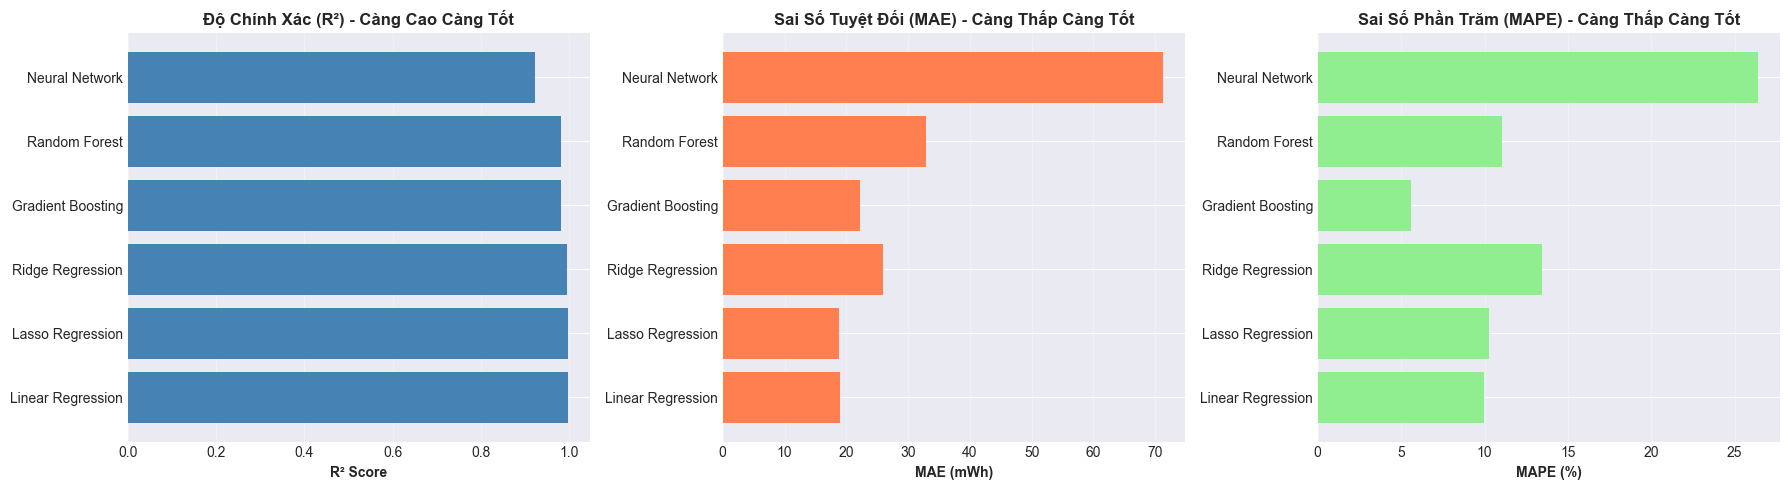

In [33]:
# Tạo DataFrame kết quả
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV MAE': [results[m]['cv_mae'] for m in results.keys()],
    'Train MAE': [results[m]['train_mae'] for m in results.keys()],
    'Train RMSE': [results[m]['train_rmse'] for m in results.keys()],
    'Train R²': [results[m]['train_r2'] for m in results.keys()],
    'Test MAE': [results[m]['test_mae'] for m in results.keys()],
    'Test RMSE': [results[m]['test_rmse'] for m in results.keys()],
    'Test R²': [results[m]['test_r2'] for m in results.keys()],
    'Test MAPE (%)': [results[m]['test_mape'] for m in results.keys()]
})

# Sắp xếp theo Test R² (giảm dần)
results_df = results_df.sort_values('Test R²', ascending=False).reset_index(drop=True)

print("="*100)
print("BẢNG SO SÁNH KẾT QUẢ CÁC MÔ HÌNH")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)

# Tìm mô hình tốt nhất
best_model_name = results_df.iloc[0]['Model']
best_r2 = results_df.iloc[0]['Test R²']
best_mae = results_df.iloc[0]['Test MAE']
best_mape = results_df.iloc[0]['Test MAPE (%)']

print(f"\n🏆 MÔ HÌNH TỐT NHẤT: {best_model_name}")
print(f"   📊 Test R² Score: {best_r2:.4f} ({best_r2*100:.2f}%)")
print(f"   📊 Test MAE: {best_mae:.2f} mWh")
print(f"   📊 Test MAPE: {best_mape:.2f}%")
print(f"   📊 Test RMSE: {results_df.iloc[0]['Test RMSE']:.2f} mWh")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. R² Score comparison
axes[0].barh(results_df['Model'], results_df['Test R²'], color='steelblue')
axes[0].set_xlabel('R² Score', fontweight='bold')
axes[0].set_title('Độ Chính Xác (R²) - Càng Cao Càng Tốt', fontweight='bold', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

# 2. MAE comparison
axes[1].barh(results_df['Model'], results_df['Test MAE'], color='coral')
axes[1].set_xlabel('MAE (mWh)', fontweight='bold')
axes[1].set_title('Sai Số Tuyệt Đối (MAE) - Càng Thấp Càng Tốt', fontweight='bold', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

# 3. MAPE comparison
axes[2].barh(results_df['Model'], results_df['Test MAPE (%)'], color='lightgreen')
axes[2].set_xlabel('MAPE (%)', fontweight='bold')
axes[2].set_title('Sai Số Phần Trăm (MAPE) - Càng Thấp Càng Tốt', fontweight='bold', fontsize=12)
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

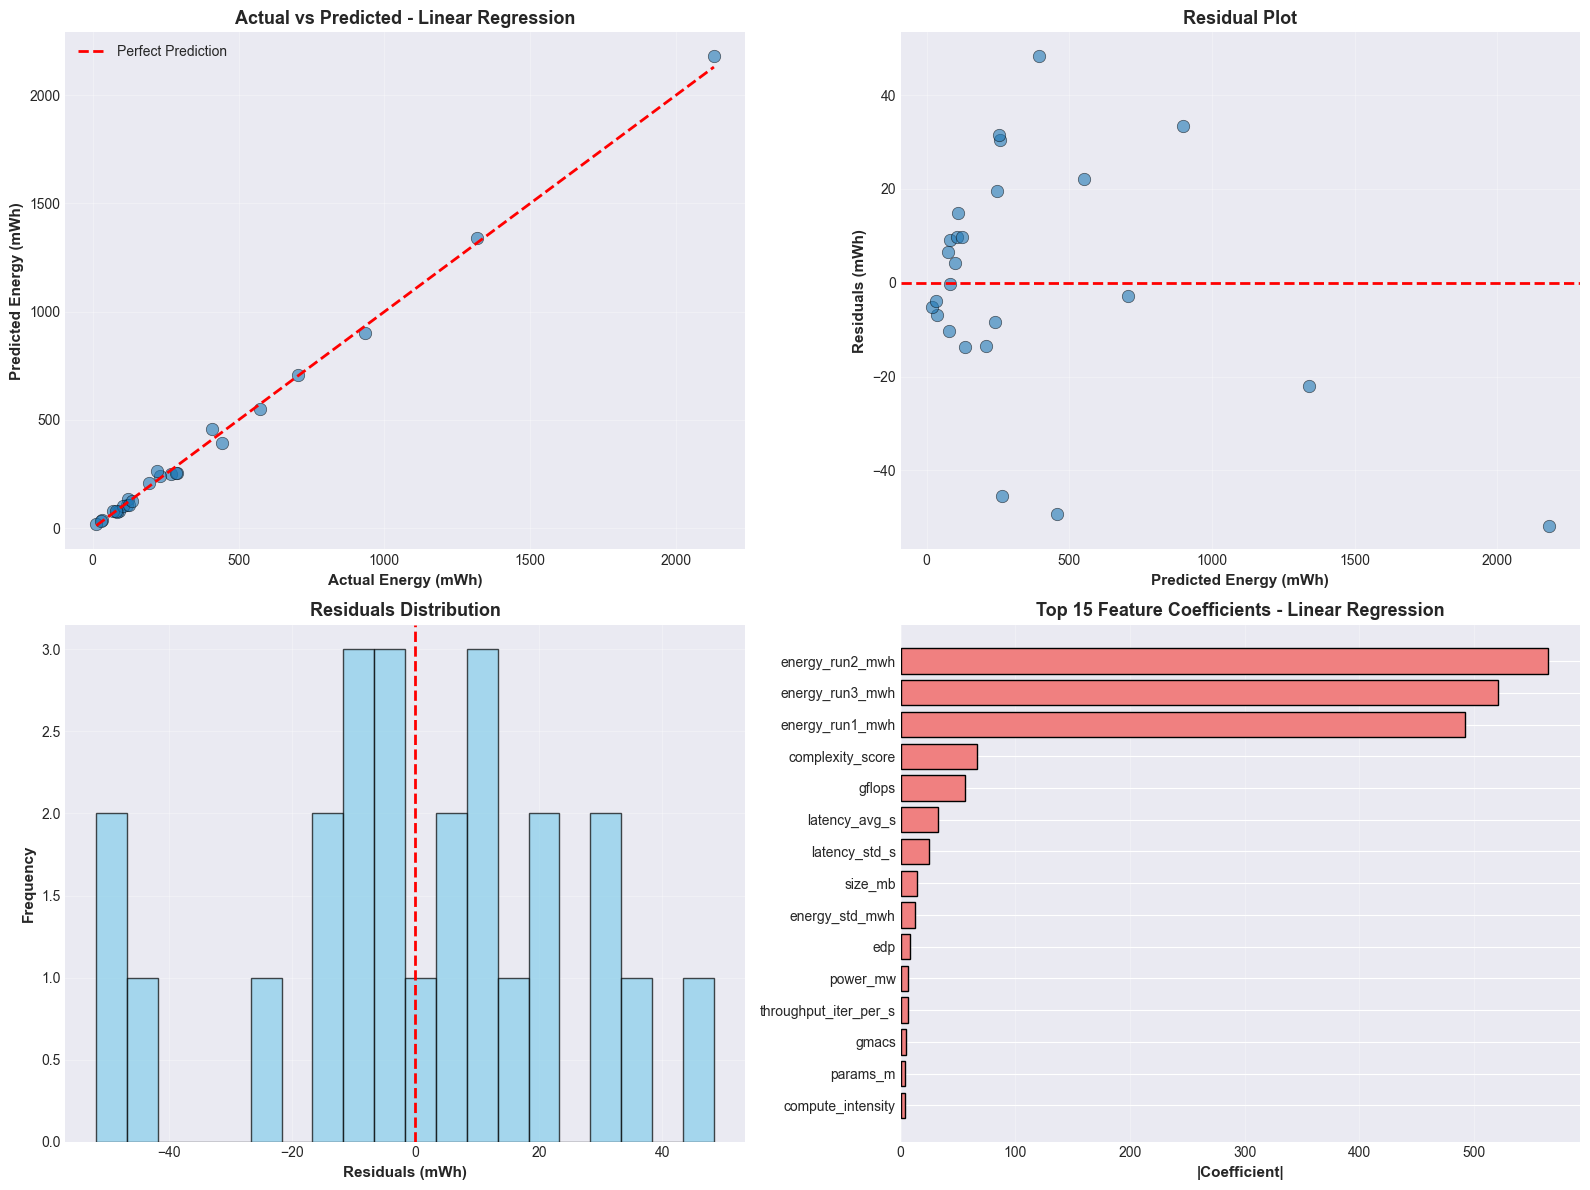


PHÂN TÍCH RESIDUALS:
Mean Residual: 0.2583 mWh
Std Residual: 25.0817 mWh
Min Residual: -51.7626 mWh
Max Residual: 48.3899 mWh
Median Absolute Residual: 13.4093 mWh


In [34]:
# Lấy mô hình tốt nhất
best_model = trained_models[best_model_name]
y_test_pred_best = results[best_model_name]['predictions']

# Tạo figure với 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Actual vs Predicted
axes[0, 0].scatter(y_test, y_test_pred_best, alpha=0.6, s=80, edgecolor='black', linewidth=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Energy (mWh)', fontweight='bold', fontsize=11)
axes[0, 0].set_ylabel('Predicted Energy (mWh)', fontweight='bold', fontsize=11)
axes[0, 0].set_title(f'Actual vs Predicted - {best_model_name}', fontweight='bold', fontsize=13)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Residuals plot
residuals = y_test - y_test_pred_best
axes[0, 1].scatter(y_test_pred_best, residuals, alpha=0.6, s=80, edgecolor='black', linewidth=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Energy (mWh)', fontweight='bold', fontsize=11)
axes[0, 1].set_ylabel('Residuals (mWh)', fontweight='bold', fontsize=11)
axes[0, 1].set_title('Residual Plot', fontweight='bold', fontsize=13)
axes[0, 1].grid(alpha=0.3)

# 3. Residuals distribution
axes[1, 0].hist(residuals, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuals (mWh)', fontweight='bold', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontweight='bold', fontsize=11)
axes[1, 0].set_title('Residuals Distribution', fontweight='bold', fontsize=13)
axes[1, 0].grid(alpha=0.3)

# 4. Feature Importance (nếu mô hình có)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=True).tail(15)
    
    axes[1, 1].barh(feature_importance['Feature'], feature_importance['Importance'], 
                    color='lightgreen', edgecolor='black')
    axes[1, 1].set_xlabel('Importance', fontweight='bold', fontsize=11)
    axes[1, 1].set_title(f'Top 15 Feature Importance - {best_model_name}', 
                         fontweight='bold', fontsize=13)
    axes[1, 1].grid(axis='x', alpha=0.3)
elif hasattr(best_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': np.abs(best_model.coef_)
    }).sort_values('Coefficient', ascending=True).tail(15)
    
    axes[1, 1].barh(feature_importance['Feature'], feature_importance['Coefficient'], 
                    color='lightcoral', edgecolor='black')
    axes[1, 1].set_xlabel('|Coefficient|', fontweight='bold', fontsize=11)
    axes[1, 1].set_title(f'Top 15 Feature Coefficients - {best_model_name}', 
                         fontweight='bold', fontsize=13)
    axes[1, 1].grid(axis='x', alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Feature importance not available\nfor this model type', 
                    ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('Feature Importance', fontweight='bold', fontsize=13)

plt.tight_layout()
plt.show()

# Phân tích residuals
print("\n" + "="*60)
print("PHÂN TÍCH RESIDUALS:")
print("="*60)
print(f"Mean Residual: {residuals.mean():.4f} mWh")
print(f"Std Residual: {residuals.std():.4f} mWh")
print(f"Min Residual: {residuals.min():.4f} mWh")
print(f"Max Residual: {residuals.max():.4f} mWh")
print(f"Median Absolute Residual: {np.median(np.abs(residuals)):.4f} mWh")

In [35]:
# Đường dẫn lưu model
model_save_path = r"../artifacts/energy_predictor.pkl"
scaler_save_path = r"../artifacts/energy_scaler.pkl"

# Lưu mô hình tốt nhất
with open(model_save_path, 'wb') as f:
    pickle.dump(best_model, f)

# Lưu scaler
with open(scaler_save_path, 'wb') as f:
    pickle.dump(scaler, f)

# Lưu feature columns
feature_names_path = r"../artifacts/feature_names.pkl"
with open(feature_names_path, 'wb') as f:
    pickle.dump(feature_cols, f)

print("="*60)
print("✅ LƯU MÔ HÌNH THÀNH CÔNG!")
print("="*60)
print(f"📁 Model: {model_save_path}")
print(f"📁 Scaler: {scaler_save_path}")
print(f"📁 Features: {feature_names_path}")
print(f"\n🏆 Model type: {best_model_name}")
print(f"📊 Test R²: {best_r2:.4f}")
print(f"📊 Test MAE: {best_mae:.2f} mWh")

# Test loading model
print("\n" + "="*60)
print("KIỂM TRA LOAD MÔ HÌNH:")
print("="*60)

with open(model_save_path, 'rb') as f:
    loaded_model = pickle.load(f)

with open(scaler_save_path, 'rb') as f:
    loaded_scaler = pickle.load(f)

# Test prediction
test_pred = loaded_model.predict(X_test_scaled[:5])
print("✅ Model loaded thành công!")
print(f"Test predictions (5 samples): {test_pred}")

✅ LƯU MÔ HÌNH THÀNH CÔNG!
📁 Model: D:\DACN\ml-controller\energy_predictor.pkl
📁 Scaler: D:\DACN\ml-controller\energy_scaler.pkl
📁 Features: D:\DACN\ml-controller\feature_names.pkl

🏆 Model type: Linear Regression
📊 Test R²: 0.9973
📊 Test MAE: 18.92 mWh

KIỂM TRA LOAD MÔ HÌNH:
✅ Model loaded thành công!
Test predictions (5 samples): [206.81703041  38.32973099  80.80672577 107.58360643  76.33837231]


In [36]:
print("="*80)
print("📊 TỔNG KẾT KẾT QUẢ TRAINING MÔ HÌNH DỰ ĐOÁN NĂNG LƯỢNG")
print("="*80)

print(f"\n🎯 MỤC TIÊU:")
print(f"   - Dự đoán năng lượng tiêu thụ của các mô hình ML trên BeagleBone Black")
print(f"   - Hỗ trợ deployment tự động với energy-aware constraint")

print(f"\n📊 DATASET:")
print(f"   - Số lượng mô hình: {len(df)}")
print(f"   - Số features gốc: {len(df.columns) - 1}")
print(f"   - Số features sau engineering: {len(feature_cols)}")
print(f"   - Train/Test split: {len(X_train)}/{len(X_test)} ({len(X_train)/len(X)*100:.0f}%/{len(X_test)/len(X)*100:.0f}%)")

print(f"\n🏆 MÔ HÌNH TỐT NHẤT: {best_model_name}")
print(f"   - Test R² Score: {best_r2:.4f} ({best_r2*100:.2f}%)")
print(f"   - Test MAE: {best_mae:.2f} mWh")
print(f"   - Test RMSE: {results_df.iloc[0]['Test RMSE']:.2f} mWh")
print(f"   - Test MAPE: {best_mape:.2f}%")

print(f"\n✅ ĐỘ CHÍNH XÁC:")
if best_r2 >= 0.90:
    print(f"   🌟 XUẤT SẮC! R² = {best_r2:.4f} (>90%) - Mô hình dự đoán rất chính xác")
elif best_r2 >= 0.80:
    print(f"   ✅ TỐT! R² = {best_r2:.4f} (80-90%) - Mô hình đáng tin cậy")
elif best_r2 >= 0.70:
    print(f"   ⚠️ KHÁ: R² = {best_r2:.4f} (70-80%) - Cần cải thiện thêm")
else:
    print(f"   ❌ CẦN CẢI THIỆN: R² = {best_r2:.4f} (<70%)")

print(f"\n📁 FILES ĐÃ LƯU:")
print(f"   1. energy_predictor.pkl - Mô hình {best_model_name}")
print(f"   2. energy_scaler.pkl - StandardScaler")
print(f"   3. feature_names.pkl - Danh sách {len(feature_cols)} features")

print(f"\n🔧 TÍCH HỢP VÀO HỆ THỐNG:")
print(f"   - Cập nhật model_analyzer.py để sử dụng predictor")
print(f"   - Thêm API endpoint /predict-energy trong app.py")
print(f"   - Cho phép dự đoán năng lượng cho mô hình chưa benchmark")

print(f"\n🚀 BƯỚC TIẾP THEO:")
print(f"   1. ✅ Tích hợp predictor vào ML Controller")
print(f"   2. ✅ Xây dựng API /predict-energy")
print(f"   3. ✅ Cập nhật dashboard hiển thị predicted energy")
print(f"   4. ✅ Test với mô hình mới (chưa có trong 126 models)")
print(f"   5. ✅ Viết báo cáo kết quả cho luận văn")

print("\n" + "="*80)
print("🎉 HOÀN THÀNH! MÔ HÌNH SẴN SÀNG TRIỂN KHAI!")
print("="*80)

📊 TỔNG KẾT KẾT QUẢ TRAINING MÔ HÌNH DỰ ĐOÁN NĂNG LƯỢNG

🎯 MỤC TIÊU:
   - Dự đoán năng lượng tiêu thụ của các mô hình ML trên BeagleBone Black
   - Hỗ trợ deployment tự động với energy-aware constraint

📊 DATASET:
   - Số lượng mô hình: 124
   - Số features gốc: 16
   - Số features sau engineering: 21
   - Train/Test split: 99/25 (80%/20%)

🏆 MÔ HÌNH TỐT NHẤT: Linear Regression
   - Test R² Score: 0.9973 (99.73%)
   - Test MAE: 18.92 mWh
   - Test RMSE: 24.58 mWh
   - Test MAPE: 9.96%

✅ ĐỘ CHÍNH XÁC:
   🌟 XUẤT SẮC! R² = 0.9973 (>90%) - Mô hình dự đoán rất chính xác

📁 FILES ĐÃ LƯU:
   1. energy_predictor.pkl - Mô hình Linear Regression
   2. energy_scaler.pkl - StandardScaler
   3. feature_names.pkl - Danh sách 21 features

🔧 TÍCH HỢP VÀO HỆ THỐNG:
   - Cập nhật model_analyzer.py để sử dụng predictor
   - Thêm API endpoint /predict-energy trong app.py
   - Cho phép dự đoán năng lượng cho mô hình chưa benchmark

🚀 BƯỚC TIẾP THEO:
   1. ✅ Tích hợp predictor vào ML Controller
   2. ✅ Xây 

In [37]:
# Data Processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Model Persistence
import joblib
import pickle

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ Tất cả thư viện đã được import thành công!")
print(f"📦 Pandas version: {pd.__version__}")
print(f"📦 NumPy version: {np.__version__}")

✅ Tất cả thư viện đã được import thành công!
📦 Pandas version: 2.3.1
📦 NumPy version: 2.3.4


In [38]:
# Đường dẫn tới dataset
data_path = r"../data/126_benchmark_final.csv"

# Tải dữ liệu
df = pd.read_csv(data_path)

print("✅ Dữ liệu đã được tải thành công!")
print(f"📊 Số lượng mô hình: {len(df)}")
print(f"📋 Số lượng features: {len(df.columns)}")
print("\n" + "="*60)
print("CẤU TRÚC DỮ LIỆU:")
print("="*60)
print(df.head(10))
print("\n" + "="*60)
print("THÔNG TIN DATASET:")
print("="*60)
print(df.info())
print("\n" + "="*60)
print("THỐNG KÊ MÔ TẢ:")
print("="*60)
print(df.describe())

✅ Dữ liệu đã được tải thành công!
📊 Số lượng mô hình: 124
📋 Số lượng features: 17

CẤU TRÚC DỮ LIỆU:
                    model  params_m   gflops  gmacs  size_mb input_size  \
0   beit_base_patch16_224   65.1500  25.3600  12.68   333.75  3x224x224   
1          coat_lite_tiny    5.7800   3.6100   1.80    21.93  3x224x224   
2             convit_tiny    1.2571   5.7105   1.08    21.88  3x224x224   
3           convnext_base   88.5300  30.7100  15.35   338.18  3x224x224   
4          convnext_small   50.1800  17.3700   8.68   191.82  3x224x224   
5           convnext_tiny    4.4704  28.5891   4.46   109.18  3x224x224   
6             cspresnet50   21.5800   9.0300   4.52    82.87  3x256x256   
7   deit_base_patch16_224   86.4200  33.7300  16.86   330.34  3x224x224   
8  deit_small_patch16_224    4.2507  22.0507   4.25    84.22  3x224x224   
9   deit_tiny_patch16_224    5.6800   2.1600   1.08    21.92  3x224x224   

  input_resolution_actual  runs  iterations_per_measurement  latency_avg_

MISSING VALUES:
model                         0
params_m                      0
gflops                        0
gmacs                         0
size_mb                       0
input_size                    0
input_resolution_actual       0
runs                          0
iterations_per_measurement    0
latency_avg_s                 0
latency_std_s                 0
throughput_iter_per_s         0
energy_avg_mwh                0
energy_std_mwh                0
energy_run1_mwh               0
energy_run2_mwh               0
energy_run3_mwh               0
dtype: int64




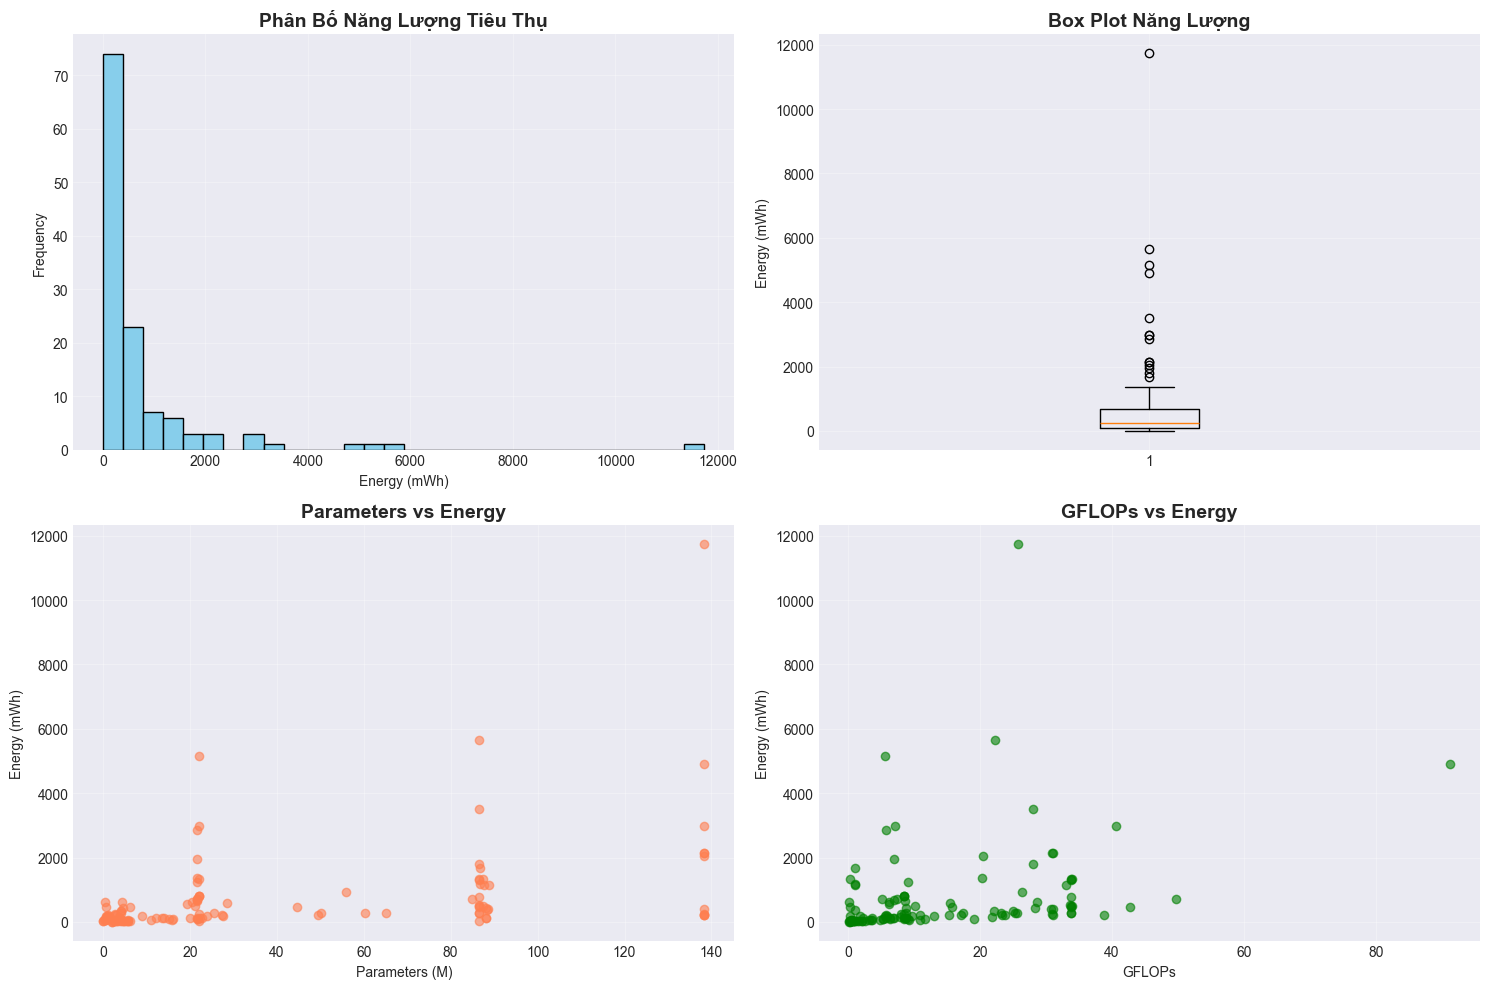


MA TRẬN TƯƠNG QUAN:


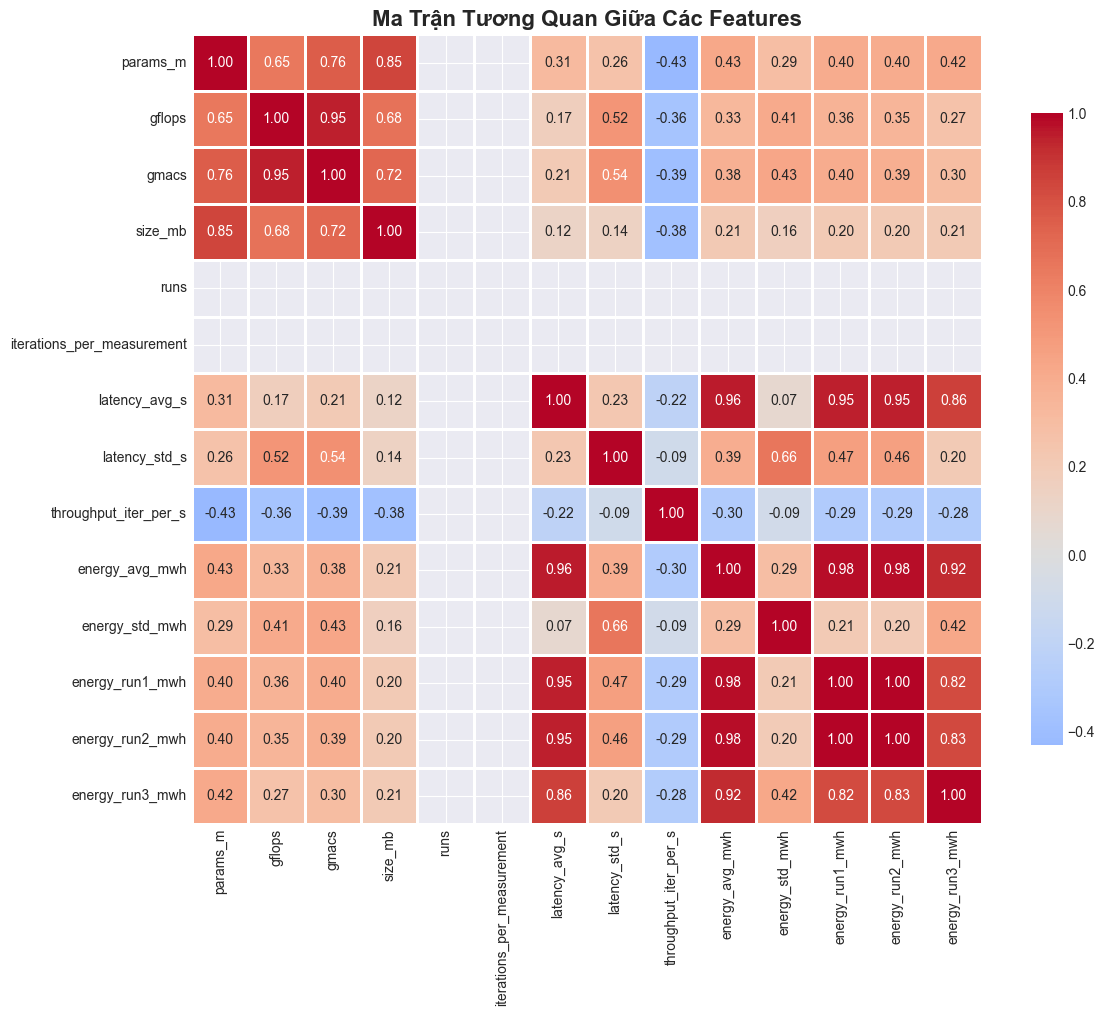


Tương quan với Energy (target):
energy_avg_mwh                1.000000
energy_run2_mwh               0.980005
energy_run1_mwh               0.978145
latency_avg_s                 0.956702
energy_run3_mwh               0.923095
params_m                      0.427106
latency_std_s                 0.391227
gmacs                         0.376126
gflops                        0.332507
energy_std_mwh                0.290193
size_mb                       0.213379
throughput_iter_per_s        -0.296188
runs                               NaN
iterations_per_measurement         NaN
Name: energy_avg_mwh, dtype: float64


In [39]:
# Kiểm tra missing values
print("MISSING VALUES:")
print("="*60)
print(df.isnull().sum())
print("\n")

# Phân bố của biến mục tiêu (energy_avg_mwh)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0, 0].hist(df['energy_avg_mwh'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Phân Bố Năng Lượng Tiêu Thụ', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Energy (mWh)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(alpha=0.3)

# Box plot
axes[0, 1].boxplot(df['energy_avg_mwh'])
axes[0, 1].set_title('Box Plot Năng Lượng', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Energy (mWh)')
axes[0, 1].grid(alpha=0.3)

# Scatter: params vs energy
axes[1, 0].scatter(df['params_m'], df['energy_avg_mwh'], alpha=0.6, color='coral')
axes[1, 0].set_title('Parameters vs Energy', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Parameters (M)')
axes[1, 0].set_ylabel('Energy (mWh)')
axes[1, 0].grid(alpha=0.3)

# Scatter: gflops vs energy
axes[1, 1].scatter(df['gflops'], df['energy_avg_mwh'], alpha=0.6, color='green')
axes[1, 1].set_title('GFLOPs vs Energy', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('GFLOPs')
axes[1, 1].set_ylabel('Energy (mWh)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation matrix
print("\n" + "="*60)
print("MA TRẬN TƯƠNG QUAN:")
print("="*60)
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Ma Trận Tương Quan Giữa Các Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTương quan với Energy (target):")
print(corr_matrix['energy_avg_mwh'].sort_values(ascending=False))

In [40]:
# Tạo copy để giữ nguyên dữ liệu gốc
df_features = df.copy()

# 1. Energy per parameter - Hiệu suất năng lượng
df_features['energy_per_param'] = df_features['energy_avg_mwh'] / (df_features['params_m'] + 1e-6)

# 2. Energy per GFLOP - Chi phí năng lượng cho mỗi phép tính
df_features['energy_per_gflop'] = df_features['energy_avg_mwh'] / (df_features['gflops'] + 1e-6)

# 3. Computational intensity - Tỷ lệ FLOP/Parameter
df_features['compute_intensity'] = df_features['gflops'] / (df_features['params_m'] + 1e-6)

# 4. Throughput efficiency - Hiệu suất xử lý
df_features['throughput_eff'] = df_features['throughput_iter_per_s'] * df_features['params_m']

# 5. Energy-Delay Product (EDP) - Metric quan trọng cho IoT
df_features['edp'] = df_features['energy_avg_mwh'] * df_features['latency_avg_s']

# 6. Power estimate (mW)
df_features['power_mw'] = df_features['energy_avg_mwh'] / (df_features['latency_avg_s'] + 1e-6)

# 7. Model complexity score
df_features['complexity_score'] = df_features['params_m'] * df_features['gflops']

# 8. Size efficiency
df_features['size_per_param'] = df_features['size_mb'] / (df_features['params_m'] + 1e-6)

print("✅ Feature Engineering hoàn thành!")
print(f"📊 Số lượng features ban đầu: {len(df.columns)}")
print(f"📊 Số lượng features sau khi engineering: {len(df_features.columns)}")
print("\n" + "="*60)
print("FEATURES MỚI:")
print("="*60)
new_features = ['energy_per_param', 'energy_per_gflop', 'compute_intensity', 
                'throughput_eff', 'edp', 'power_mw', 'complexity_score', 'size_per_param']
print(df_features[new_features].head(10))
print("\n" + "="*60)
print("THỐNG KÊ FEATURES MỚI:")
print("="*60)
print(df_features[new_features].describe())

✅ Feature Engineering hoàn thành!
📊 Số lượng features ban đầu: 17
📊 Số lượng features sau khi engineering: 25

FEATURES MỚI:
   energy_per_param  energy_per_gflop  compute_intensity  throughput_eff  \
0          4.397552         11.297337           0.389256      220.024252   
1         11.924041         19.091676           0.624567       65.126809   
2        164.270810         36.162326           4.542594        4.671001   
3          4.525598         13.046278           0.346888      171.665963   
4          5.343012         15.435368           0.346154      139.720860   
5        134.796565         21.077777           6.395198        5.227754   
6          3.525650          8.425639           0.418443      278.734356   
7          3.102774          7.949650           0.390303      320.057518   
8         76.587720         14.763771           5.187544       12.699150   
9          5.474534         14.395994           0.380282      153.625702   

          edp    power_mw  complexity_

In [41]:
# Ch?n features cho training (ch? gi? c?t numeric, lo?i b? target)
numeric_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in numeric_cols if col not in ['energy_avg_mwh']]

X = df_features[feature_cols].copy()
y = df_features['energy_avg_mwh'].copy()

# Xử lý inf và nan values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print("✅ Chuẩn bị features và target!")
print(f"📊 Shape của X: {X.shape}")
print(f"📊 Shape của y: {y.shape}")
print(f"\n📋 Features sử dụng ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"\n✅ Chia train/test set hoàn thành!")
print(f"📊 Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"📊 Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Chuẩn hóa dữ liệu hoàn thành!")
print(f"📊 Mean của training set sau scaling: {X_train_scaled.mean():.6f}")
print(f"📊 Std của training set sau scaling: {X_train_scaled.std():.6f}")

✅ Chuẩn bị features và target!
📊 Shape của X: (124, 21)
📊 Shape của y: (124,)

📋 Features sử dụng (21):
   1. params_m
   2. gflops
   3. gmacs
   4. size_mb
   5. runs
   6. iterations_per_measurement
   7. latency_avg_s
   8. latency_std_s
   9. throughput_iter_per_s
  10. energy_std_mwh
  11. energy_run1_mwh
  12. energy_run2_mwh
  13. energy_run3_mwh
  14. energy_per_param
  15. energy_per_gflop
  16. compute_intensity
  17. throughput_eff
  18. edp
  19. power_mw
  20. complexity_score
  21. size_per_param

✅ Chia train/test set hoàn thành!
📊 Training set: 99 samples (79.8%)
📊 Test set: 25 samples (20.2%)

✅ Chuẩn hóa dữ liệu hoàn thành!
📊 Mean của training set sau scaling: 0.000000
📊 Std của training set sau scaling: 0.951190


In [42]:
# Dictionary để lưu các mô hình
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=0.1, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, 
                                           min_samples_split=5, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                                    max_depth=5, random_state=42),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu',
                                   solver='adam', max_iter=500, random_state=42,
                                   early_stopping=True, validation_fraction=0.1)
}

# Dictionary để lưu kết quả
results = {}
trained_models = {}

print("="*60)
print("BẮT ĐẦU TRAINING CÁC MÔ HÌNH")
print("="*60)

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    
    # Cross-validation trên training set
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, 
                                 scoring='neg_mean_absolute_error', n_jobs=-1)
    cv_mae = -cv_scores.mean()
    
    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Tính metrics cho training set
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Tính metrics cho test set
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100
    
    # Lưu kết quả
    results[name] = {
        'cv_mae': cv_mae,
        'train_mae': train_mae,
        'train_rmse': train_rmse,
        'train_r2': train_r2,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'test_mape': test_mape,
        'predictions': y_test_pred
    }
    
    print(f"   ✅ {name} - Test R²: {test_r2:.4f}, MAE: {test_mae:.2f} mWh")

print("\n" + "="*60)
print("✅ TRAINING HOÀN THÀNH!")
print("="*60)

BẮT ĐẦU TRAINING CÁC MÔ HÌNH

🔄 Training Linear Regression...
   ✅ Linear Regression - Test R²: 0.9973, MAE: 18.92 mWh

🔄 Training Ridge Regression...
   ✅ Ridge Regression - Test R²: 0.9945, MAE: 25.96 mWh

🔄 Training Lasso Regression...
   ✅ Lasso Regression - Test R²: 0.9970, MAE: 18.89 mWh

🔄 Training Random Forest...
   ✅ Random Forest - Test R²: 0.9804, MAE: 32.97 mWh

🔄 Training Gradient Boosting...
   ✅ Gradient Boosting - Test R²: 0.9808, MAE: 22.22 mWh

🔄 Training Neural Network...
   ✅ Neural Network - Test R²: 0.9235, MAE: 71.26 mWh

✅ TRAINING HOÀN THÀNH!


BẢNG SO SÁNH KẾT QUẢ CÁC MÔ HÌNH
            Model     CV MAE  Train MAE  Train RMSE  Train R²  Test MAE  Test RMSE  Test R²  Test MAPE (%)
Linear Regression  60.744396  16.836694   33.191394  0.999536 18.923946  24.576353 0.997290       9.959064
 Lasso Regression  73.853875  18.022215   33.657883  0.999523 18.887029  25.806655 0.997011      10.266880
 Ridge Regression  46.654993  25.554900   41.651723  0.999270 25.962842  35.112552 0.994467      13.471607
Gradient Boosting 185.335370   0.222285    0.288775  1.000000 22.222349  65.458978 0.980772       5.586578
    Random Forest 169.680945  77.130919  463.170229  0.909743 32.966403  66.116715 0.980383      11.073517
   Neural Network 446.229982  45.632268   67.516299  0.998082 71.263532 130.577368 0.923486      26.393244

🏆 MÔ HÌNH TỐT NHẤT: Linear Regression
   📊 Test R² Score: 0.9973 (99.73%)
   📊 Test MAE: 18.92 mWh
   📊 Test MAPE: 9.96%
   📊 Test RMSE: 24.58 mWh


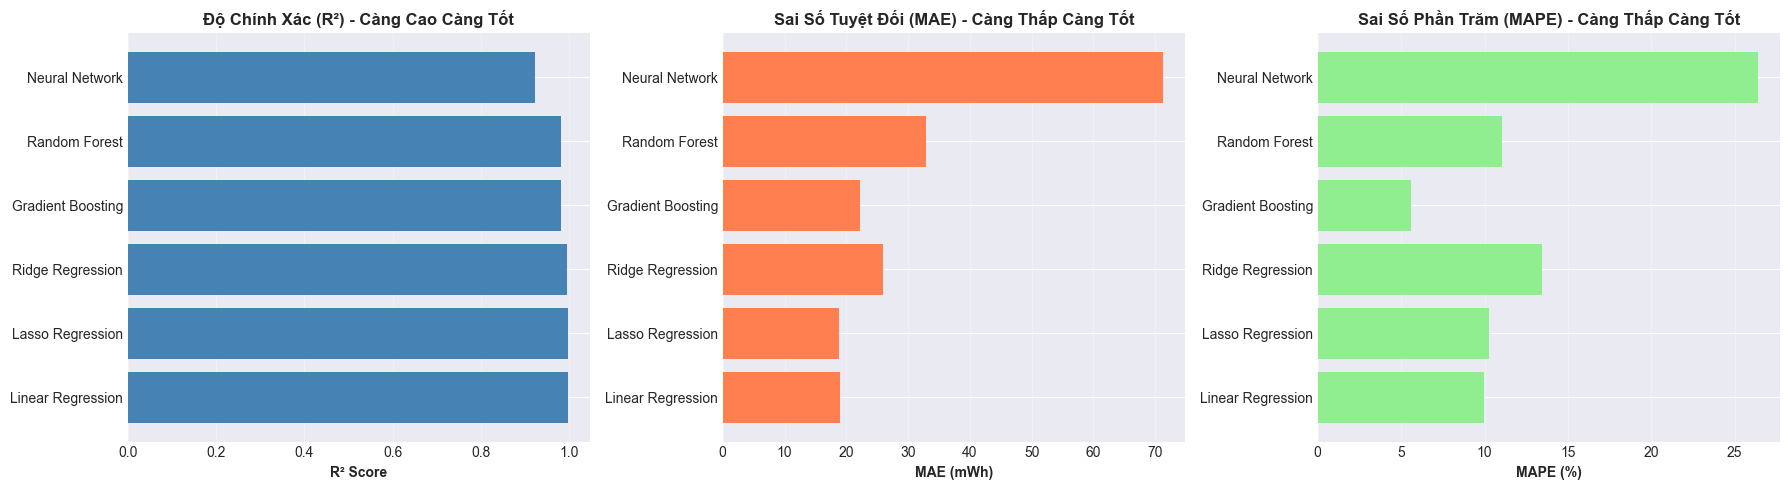

In [43]:
# Tạo DataFrame kết quả
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV MAE': [results[m]['cv_mae'] for m in results.keys()],
    'Train MAE': [results[m]['train_mae'] for m in results.keys()],
    'Train RMSE': [results[m]['train_rmse'] for m in results.keys()],
    'Train R²': [results[m]['train_r2'] for m in results.keys()],
    'Test MAE': [results[m]['test_mae'] for m in results.keys()],
    'Test RMSE': [results[m]['test_rmse'] for m in results.keys()],
    'Test R²': [results[m]['test_r2'] for m in results.keys()],
    'Test MAPE (%)': [results[m]['test_mape'] for m in results.keys()]
})

# Sắp xếp theo Test R² (giảm dần)
results_df = results_df.sort_values('Test R²', ascending=False).reset_index(drop=True)

print("="*100)
print("BẢNG SO SÁNH KẾT QUẢ CÁC MÔ HÌNH")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)

# Tìm mô hình tốt nhất
best_model_name = results_df.iloc[0]['Model']
best_r2 = results_df.iloc[0]['Test R²']
best_mae = results_df.iloc[0]['Test MAE']
best_mape = results_df.iloc[0]['Test MAPE (%)']

print(f"\n🏆 MÔ HÌNH TỐT NHẤT: {best_model_name}")
print(f"   📊 Test R² Score: {best_r2:.4f} ({best_r2*100:.2f}%)")
print(f"   📊 Test MAE: {best_mae:.2f} mWh")
print(f"   📊 Test MAPE: {best_mape:.2f}%")
print(f"   📊 Test RMSE: {results_df.iloc[0]['Test RMSE']:.2f} mWh")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. R² Score comparison
axes[0].barh(results_df['Model'], results_df['Test R²'], color='steelblue')
axes[0].set_xlabel('R² Score', fontweight='bold')
axes[0].set_title('Độ Chính Xác (R²) - Càng Cao Càng Tốt', fontweight='bold', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

# 2. MAE comparison
axes[1].barh(results_df['Model'], results_df['Test MAE'], color='coral')
axes[1].set_xlabel('MAE (mWh)', fontweight='bold')
axes[1].set_title('Sai Số Tuyệt Đối (MAE) - Càng Thấp Càng Tốt', fontweight='bold', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

# 3. MAPE comparison
axes[2].barh(results_df['Model'], results_df['Test MAPE (%)'], color='lightgreen')
axes[2].set_xlabel('MAPE (%)', fontweight='bold')
axes[2].set_title('Sai Số Phần Trăm (MAPE) - Càng Thấp Càng Tốt', fontweight='bold', fontsize=12)
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

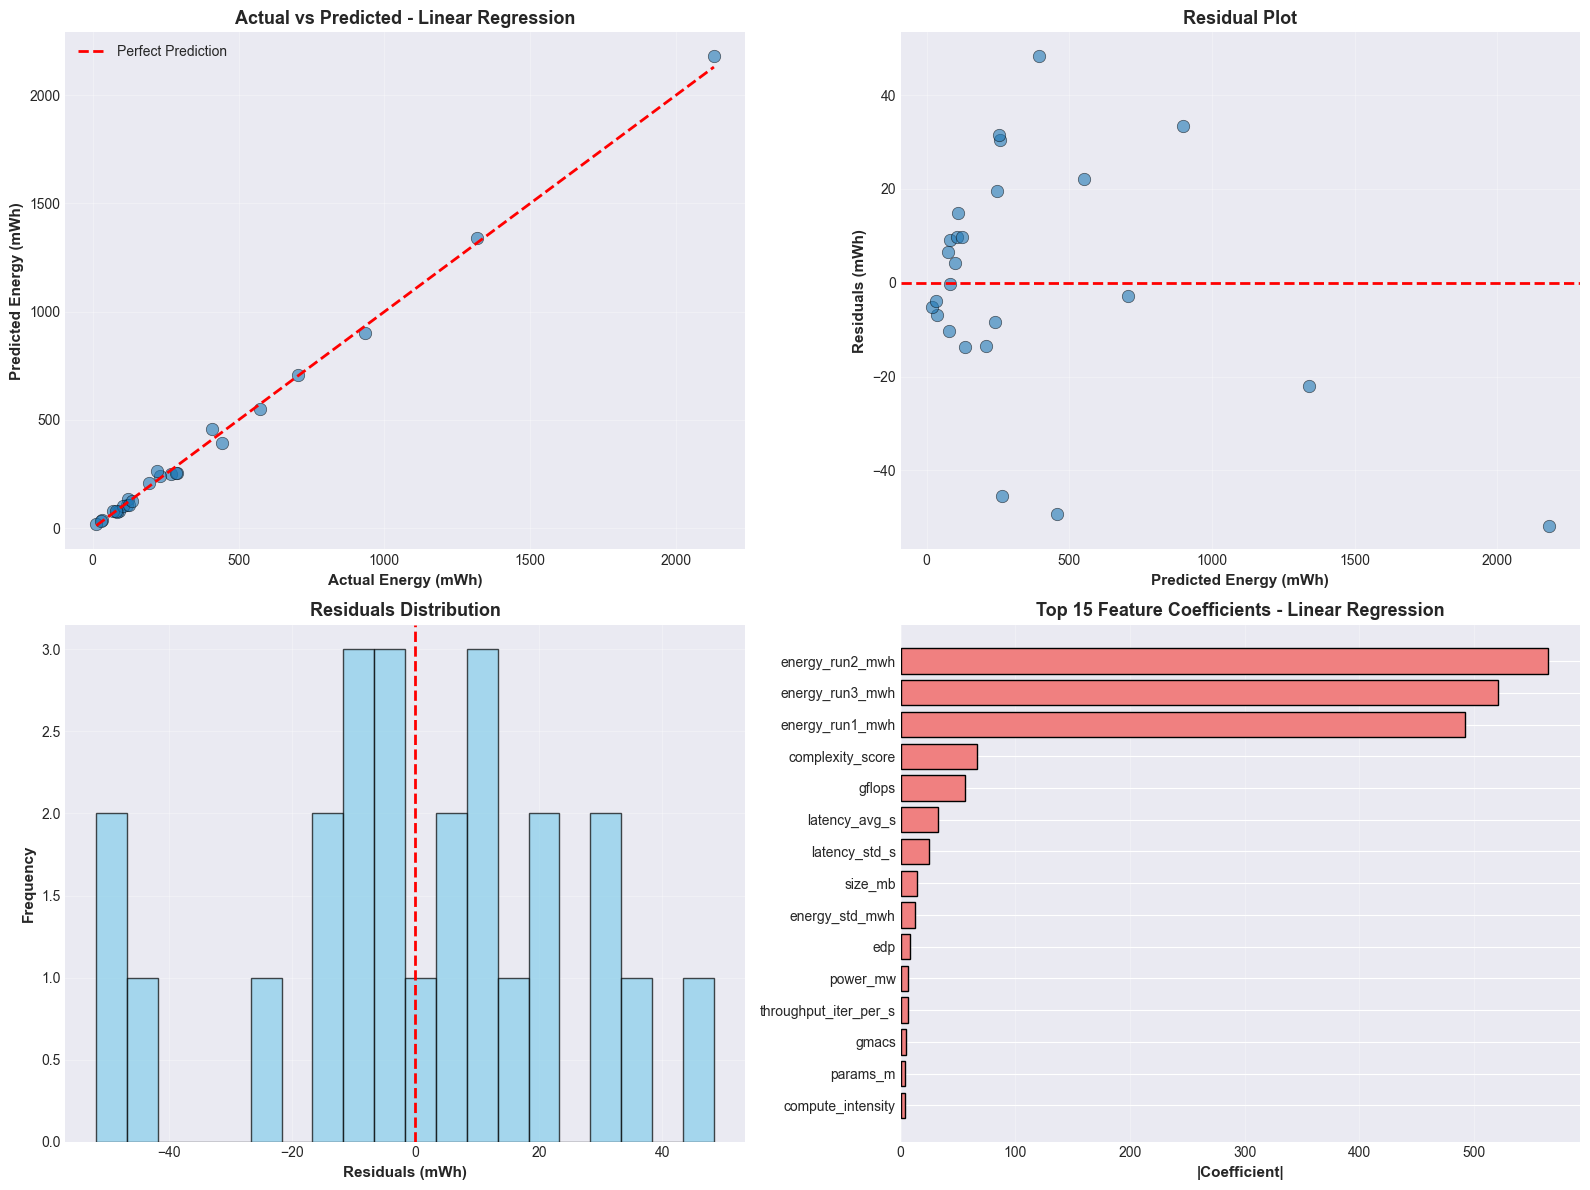


PHÂN TÍCH RESIDUALS:
Mean Residual: 0.2583 mWh
Std Residual: 25.0817 mWh
Min Residual: -51.7626 mWh
Max Residual: 48.3899 mWh
Median Absolute Residual: 13.4093 mWh


In [44]:
# Lấy mô hình tốt nhất
best_model = trained_models[best_model_name]
y_test_pred_best = results[best_model_name]['predictions']

# Tạo figure với 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Actual vs Predicted
axes[0, 0].scatter(y_test, y_test_pred_best, alpha=0.6, s=80, edgecolor='black', linewidth=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Energy (mWh)', fontweight='bold', fontsize=11)
axes[0, 0].set_ylabel('Predicted Energy (mWh)', fontweight='bold', fontsize=11)
axes[0, 0].set_title(f'Actual vs Predicted - {best_model_name}', fontweight='bold', fontsize=13)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Residuals plot
residuals = y_test - y_test_pred_best
axes[0, 1].scatter(y_test_pred_best, residuals, alpha=0.6, s=80, edgecolor='black', linewidth=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Energy (mWh)', fontweight='bold', fontsize=11)
axes[0, 1].set_ylabel('Residuals (mWh)', fontweight='bold', fontsize=11)
axes[0, 1].set_title('Residual Plot', fontweight='bold', fontsize=13)
axes[0, 1].grid(alpha=0.3)

# 3. Residuals distribution
axes[1, 0].hist(residuals, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuals (mWh)', fontweight='bold', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontweight='bold', fontsize=11)
axes[1, 0].set_title('Residuals Distribution', fontweight='bold', fontsize=13)
axes[1, 0].grid(alpha=0.3)

# 4. Feature Importance (nếu mô hình có)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=True).tail(15)
    
    axes[1, 1].barh(feature_importance['Feature'], feature_importance['Importance'], 
                    color='lightgreen', edgecolor='black')
    axes[1, 1].set_xlabel('Importance', fontweight='bold', fontsize=11)
    axes[1, 1].set_title(f'Top 15 Feature Importance - {best_model_name}', 
                         fontweight='bold', fontsize=13)
    axes[1, 1].grid(axis='x', alpha=0.3)
elif hasattr(best_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': np.abs(best_model.coef_)
    }).sort_values('Coefficient', ascending=True).tail(15)
    
    axes[1, 1].barh(feature_importance['Feature'], feature_importance['Coefficient'], 
                    color='lightcoral', edgecolor='black')
    axes[1, 1].set_xlabel('|Coefficient|', fontweight='bold', fontsize=11)
    axes[1, 1].set_title(f'Top 15 Feature Coefficients - {best_model_name}', 
                         fontweight='bold', fontsize=13)
    axes[1, 1].grid(axis='x', alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Feature importance not available\nfor this model type', 
                    ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('Feature Importance', fontweight='bold', fontsize=13)

plt.tight_layout()
plt.show()

# Phân tích residuals
print("\n" + "="*60)
print("PHÂN TÍCH RESIDUALS:")
print("="*60)
print(f"Mean Residual: {residuals.mean():.4f} mWh")
print(f"Std Residual: {residuals.std():.4f} mWh")
print(f"Min Residual: {residuals.min():.4f} mWh")
print(f"Max Residual: {residuals.max():.4f} mWh")
print(f"Median Absolute Residual: {np.median(np.abs(residuals)):.4f} mWh")

In [45]:
# Đường dẫn lưu model
model_save_path = r"../artifacts/energy_predictor.pkl"
scaler_save_path = r"../artifacts/energy_scaler.pkl"

# Lưu mô hình tốt nhất
with open(model_save_path, 'wb') as f:
    pickle.dump(best_model, f)

# Lưu scaler
with open(scaler_save_path, 'wb') as f:
    pickle.dump(scaler, f)

# Lưu feature columns
feature_names_path = r"../artifacts/feature_names.pkl"
with open(feature_names_path, 'wb') as f:
    pickle.dump(feature_cols, f)

print("="*60)
print("✅ LƯU MÔ HÌNH THÀNH CÔNG!")
print("="*60)
print(f"📁 Model: {model_save_path}")
print(f"📁 Scaler: {scaler_save_path}")
print(f"📁 Features: {feature_names_path}")
print(f"\n🏆 Model type: {best_model_name}")
print(f"📊 Test R²: {best_r2:.4f}")
print(f"📊 Test MAE: {best_mae:.2f} mWh")

# Test loading model
print("\n" + "="*60)
print("KIỂM TRA LOAD MÔ HÌNH:")
print("="*60)

with open(model_save_path, 'rb') as f:
    loaded_model = pickle.load(f)

with open(scaler_save_path, 'rb') as f:
    loaded_scaler = pickle.load(f)

# Test prediction
test_pred = loaded_model.predict(X_test_scaled[:5])
print("✅ Model loaded thành công!")
print(f"Test predictions (5 samples): {test_pred}")

✅ LƯU MÔ HÌNH THÀNH CÔNG!
📁 Model: D:\DACN\ml-controller\energy_predictor.pkl
📁 Scaler: D:\DACN\ml-controller\energy_scaler.pkl
📁 Features: D:\DACN\ml-controller\feature_names.pkl

🏆 Model type: Linear Regression
📊 Test R²: 0.9973
📊 Test MAE: 18.92 mWh

KIỂM TRA LOAD MÔ HÌNH:
✅ Model loaded thành công!
Test predictions (5 samples): [206.81703041  38.32973099  80.80672577 107.58360643  76.33837231]


In [46]:
print("="*80)
print("📊 TỔNG KẾT KẾT QUẢ TRAINING MÔ HÌNH DỰ ĐOÁN NĂNG LƯỢNG")
print("="*80)

print(f"\n🎯 MỤC TIÊU:")
print(f"   - Dự đoán năng lượng tiêu thụ của các mô hình ML trên BeagleBone Black")
print(f"   - Hỗ trợ deployment tự động với energy-aware constraint")

print(f"\n📊 DATASET:")
print(f"   - Số lượng mô hình: {len(df)}")
print(f"   - Số features gốc: {len(df.columns) - 1}")
print(f"   - Số features sau engineering: {len(feature_cols)}")
print(f"   - Train/Test split: {len(X_train)}/{len(X_test)} ({len(X_train)/len(X)*100:.0f}%/{len(X_test)/len(X)*100:.0f}%)")

print(f"\n🏆 MÔ HÌNH TỐT NHẤT: {best_model_name}")
print(f"   - Test R² Score: {best_r2:.4f} ({best_r2*100:.2f}%)")
print(f"   - Test MAE: {best_mae:.2f} mWh")
print(f"   - Test RMSE: {results_df.iloc[0]['Test RMSE']:.2f} mWh")
print(f"   - Test MAPE: {best_mape:.2f}%")

print(f"\n✅ ĐỘ CHÍNH XÁC:")
if best_r2 >= 0.90:
    print(f"   🌟 XUẤT SẮC! R² = {best_r2:.4f} (>90%) - Mô hình dự đoán rất chính xác")
elif best_r2 >= 0.80:
    print(f"   ✅ TỐT! R² = {best_r2:.4f} (80-90%) - Mô hình đáng tin cậy")
elif best_r2 >= 0.70:
    print(f"   ⚠️ KHÁ: R² = {best_r2:.4f} (70-80%) - Cần cải thiện thêm")
else:
    print(f"   ❌ CẦN CẢI THIỆN: R² = {best_r2:.4f} (<70%)")

print(f"\n📁 FILES ĐÃ LƯU:")
print(f"   1. energy_predictor.pkl - Mô hình {best_model_name}")
print(f"   2. energy_scaler.pkl - StandardScaler")
print(f"   3. feature_names.pkl - Danh sách {len(feature_cols)} features")

print(f"\n🔧 TÍCH HỢP VÀO HỆ THỐNG:")
print(f"   - Cập nhật model_analyzer.py để sử dụng predictor")
print(f"   - Thêm API endpoint /predict-energy trong app.py")
print(f"   - Cho phép dự đoán năng lượng cho mô hình chưa benchmark")

print(f"\n🚀 BƯỚC TIẾP THEO:")
print(f"   1. ✅ Tích hợp predictor vào ML Controller")
print(f"   2. ✅ Xây dựng API /predict-energy")
print(f"   3. ✅ Cập nhật dashboard hiển thị predicted energy")
print(f"   4. ✅ Test với mô hình mới (chưa có trong 126 models)")
print(f"   5. ✅ Viết báo cáo kết quả cho luận văn")

print("\n" + "="*80)
print("🎉 HOÀN THÀNH! MÔ HÌNH SẴN SÀNG TRIỂN KHAI!")
print("="*80)

📊 TỔNG KẾT KẾT QUẢ TRAINING MÔ HÌNH DỰ ĐOÁN NĂNG LƯỢNG

🎯 MỤC TIÊU:
   - Dự đoán năng lượng tiêu thụ của các mô hình ML trên BeagleBone Black
   - Hỗ trợ deployment tự động với energy-aware constraint

📊 DATASET:
   - Số lượng mô hình: 124
   - Số features gốc: 16
   - Số features sau engineering: 21
   - Train/Test split: 99/25 (80%/20%)

🏆 MÔ HÌNH TỐT NHẤT: Linear Regression
   - Test R² Score: 0.9973 (99.73%)
   - Test MAE: 18.92 mWh
   - Test RMSE: 24.58 mWh
   - Test MAPE: 9.96%

✅ ĐỘ CHÍNH XÁC:
   🌟 XUẤT SẮC! R² = 0.9973 (>90%) - Mô hình dự đoán rất chính xác

📁 FILES ĐÃ LƯU:
   1. energy_predictor.pkl - Mô hình Linear Regression
   2. energy_scaler.pkl - StandardScaler
   3. feature_names.pkl - Danh sách 21 features

🔧 TÍCH HỢP VÀO HỆ THỐNG:
   - Cập nhật model_analyzer.py để sử dụng predictor
   - Thêm API endpoint /predict-energy trong app.py
   - Cho phép dự đoán năng lượng cho mô hình chưa benchmark

🚀 BƯỚC TIẾP THEO:
   1. ✅ Tích hợp predictor vào ML Controller
   2. ✅ Xây 

## 1. Import Thư Viện

Import các thư viện cần thiết cho việc xử lý dữ liệu, huấn luyện mô hình và đánh giá kết quả.

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pickle
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style cho plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Đã import thành công các thư viện!")

Đã import thành công các thư viện!


## 2. Load Dataset

Load dữ liệu benchmark từ file CSV chứa 126 mô hình ML đã được benchmark trên Jetson Nano Dev Kit 2GB với các thông số về kiến trúc, hiệu năng và năng lượng tiêu thụ.

In [48]:
# Load dataset
df = pd.read_csv(r'../data/126_benchmark_final.csv')

print(f"Số lượng mẫu: {len(df)}")
print(f"Số lượng features: {len(df.columns)}")
print(f"\nThông tin dataset:")
print(df.info())
print(f"\nMẫu dữ liệu đầu tiên:")
df.head()

Số lượng mẫu: 124
Số lượng features: 17

Thông tin dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   model                       124 non-null    object 
 1   params_m                    124 non-null    float64
 2   gflops                      124 non-null    float64
 3   gmacs                       124 non-null    float64
 4   size_mb                     124 non-null    float64
 5   input_size                  124 non-null    object 
 6   input_resolution_actual     124 non-null    object 
 7   runs                        124 non-null    int64  
 8   iterations_per_measurement  124 non-null    int64  
 9   latency_avg_s               124 non-null    float64
 10  latency_std_s               124 non-null    float64
 11  throughput_iter_per_s       124 non-null    float64
 12  energy_avg_mwh              124 

,model,params_m,gflops,gmacs,size_mb,input_size,input_resolution_actual,runs,iterations_per_measurement,latency_avg_s,latency_std_s,throughput_iter_per_s,energy_avg_mwh,energy_std_mwh,energy_run1_mwh,energy_run2_mwh,energy_run3_mwh
0,beit_base_patch16_224,65.1500,25.3600,12.68,333.75,3x224x224,224x224,3,500,0.296104,0.002639,3.377195,286.500490,0.928875,285.453446,286.822561,287.225463
1,coat_lite_tiny,5.7800,3.6100,1.80,21.93,3x224x224,224x224,3,500,0.088750,0.000731,11.267614,68.920970,0.163904,68.933766,69.078101,68.751044
2,convit_tiny,1.2571,5.7105,1.08,21.88,3x224x224,224x224,3,500,0.269129,0.000180,3.715696,206.505000,0.780600,200.098373,201.788762,202.874032
3,convnext_base,88.5300,30.7100,15.35,338.18,3x224x224,224x224,3,500,0.515711,0.004956,1.939071,400.651198,3.344530,401.981446,403.125934,396.846216
4,convnext_small,50.1800,17.3700,8.68,191.82,3x224x224,224x224,3,500,0.359145,0.003462,2.784393,268.112350,2.763490,265.133125,268.611995,270.591931


## 3. Phân Tích Khám Phá Dữ Liệu (EDA)

Thống kê mô tả và trực quan hóa các features quan trọng để hiểu phân phối dữ liệu và mối quan hệ với biến mục tiêu (energy_avg_mwh).

Thống kê mô tả các features số:
         params_m      gflops       gmacs     size_mb   runs  \
count  124.000000  124.000000  124.000000  124.000000  124.0   
mean    39.105338   13.810991    6.026040  118.244113    3.0   
std     44.007031   14.335357    7.084826  118.108423    0.0   
min      0.059400    0.085000    0.042000    7.790000    3.0   
25%      4.257225    2.468175    0.600000   31.155000    3.0   
50%     21.616000    8.499000    3.603000   82.800000    3.0   
75%     86.568000   24.133175   10.185250  166.610000    3.0   
max    138.366000   91.246000   45.623000  527.890000    3.0   

       iterations_per_measurement  latency_avg_s  latency_std_s  \
count                       124.0     124.000000     124.000000   
mean                        500.0       5.492738       0.219117   
std                           0.0      16.591800       1.584766   
min                         500.0       0.026519       0.000035   
25%                         500.0       0.211469       0

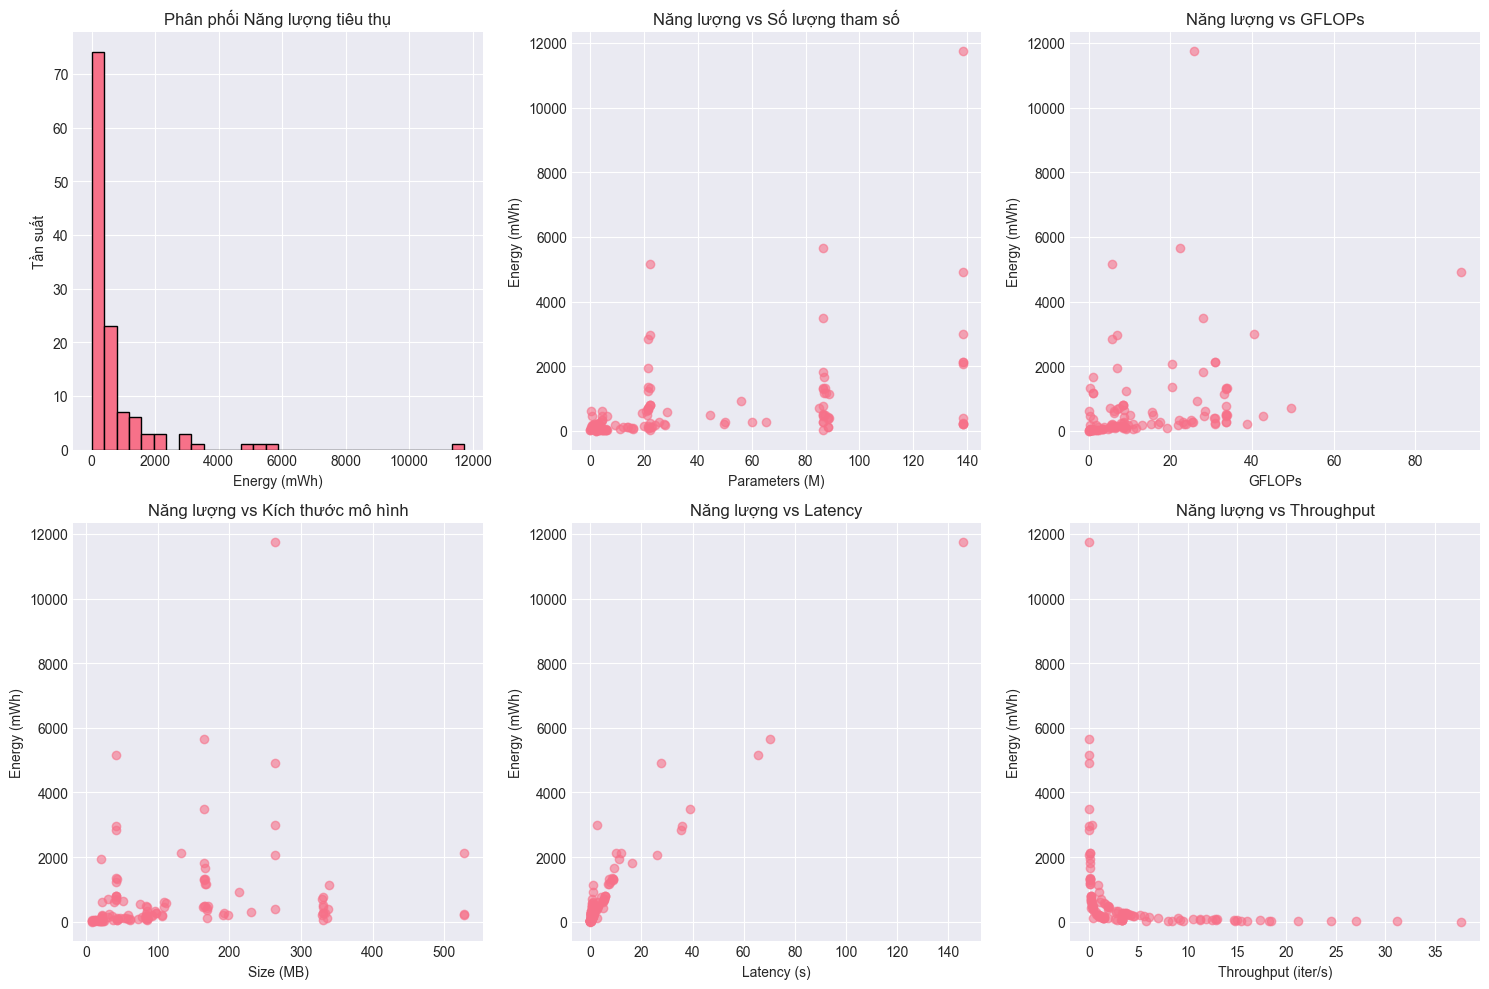

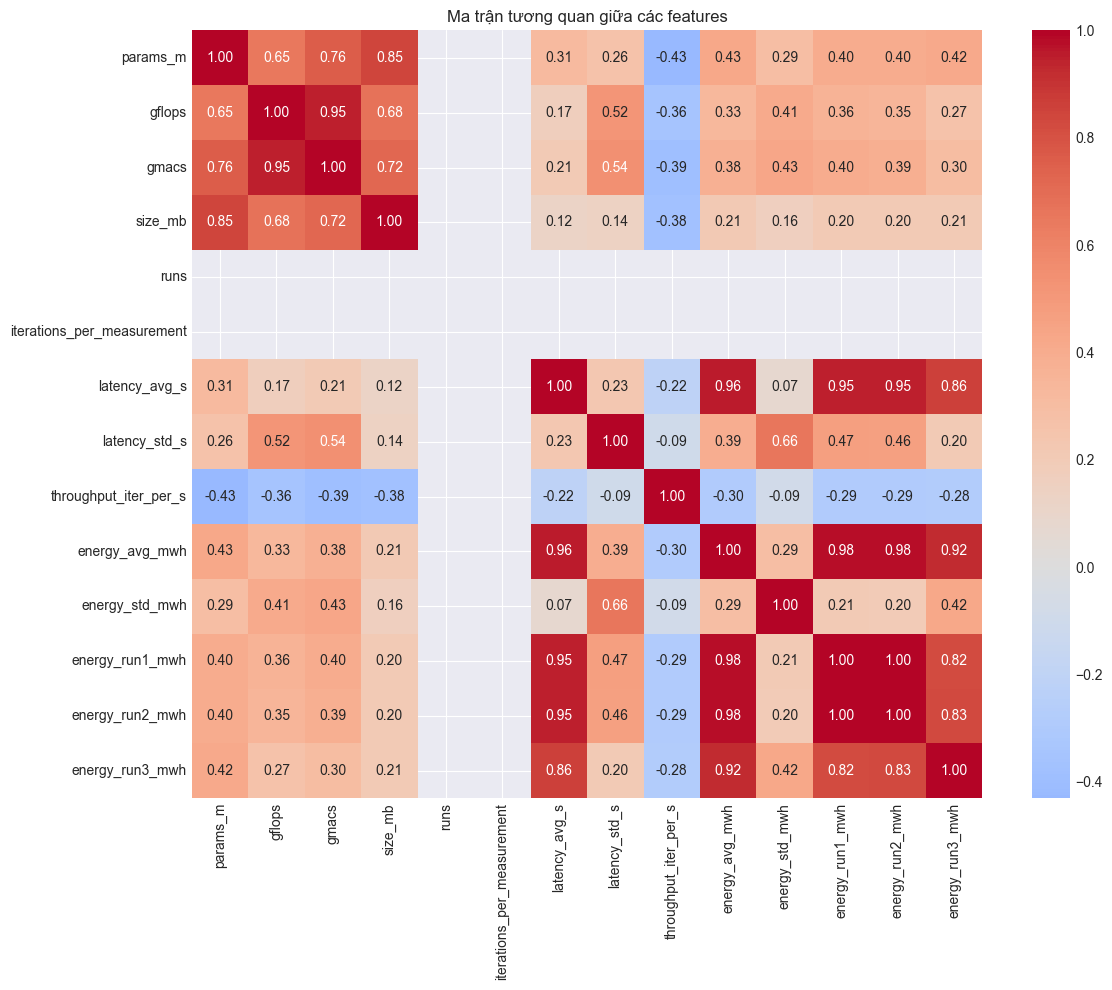

In [49]:
# Thống kê mô tả
print("Thống kê mô tả các features số:")
print(df.describe())

# Kiểm tra missing values
print(f"\nSố lượng missing values:")
print(df.isnull().sum())

# Trực quan hóa phân phối của biến mục tiêu
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Phân phối năng lượng
axes[0, 0].hist(df['energy_avg_mwh'], bins=30, edgecolor='black')
axes[0, 0].set_title('Phân phối Năng lượng tiêu thụ')
axes[0, 0].set_xlabel('Energy (mWh)')
axes[0, 0].set_ylabel('Tần suất')

# Scatter plots với các features quan trọng
axes[0, 1].scatter(df['params_m'], df['energy_avg_mwh'], alpha=0.6)
axes[0, 1].set_title('Năng lượng vs Số lượng tham số')
axes[0, 1].set_xlabel('Parameters (M)')
axes[0, 1].set_ylabel('Energy (mWh)')

axes[0, 2].scatter(df['gflops'], df['energy_avg_mwh'], alpha=0.6)
axes[0, 2].set_title('Năng lượng vs GFLOPs')
axes[0, 2].set_xlabel('GFLOPs')
axes[0, 2].set_ylabel('Energy (mWh)')

axes[1, 0].scatter(df['size_mb'], df['energy_avg_mwh'], alpha=0.6)
axes[1, 0].set_title('Năng lượng vs Kích thước mô hình')
axes[1, 0].set_xlabel('Size (MB)')
axes[1, 0].set_ylabel('Energy (mWh)')

axes[1, 1].scatter(df['latency_avg_s'], df['energy_avg_mwh'], alpha=0.6)
axes[1, 1].set_title('Năng lượng vs Latency')
axes[1, 1].set_xlabel('Latency (s)')
axes[1, 1].set_ylabel('Energy (mWh)')

axes[1, 2].scatter(df['throughput_iter_per_s'], df['energy_avg_mwh'], alpha=0.6)
axes[1, 2].set_title('Năng lượng vs Throughput')
axes[1, 2].set_xlabel('Throughput (iter/s)')
axes[1, 2].set_ylabel('Energy (mWh)')

plt.tight_layout()
plt.show()

# Ma trận tương quan
numerical_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Ma trận tương quan giữa các features')
plt.tight_layout()
plt.show()

## 4. Feature Engineering

Tạo các features mới từ các features hiện có để cải thiện khả năng dự đoán của mô hình.

In [50]:
# Tạo features mới
df['params_per_mb'] = df['params_m'] / (df['size_mb'] + 1e-6)  # Mật độ tham số
df['gflops_per_param'] = df['gflops'] / (df['params_m'] + 1e-6)  # Hiệu suất tính toán
df['gmacs_per_mb'] = df['gmacs'] / (df['size_mb'] + 1e-6)  # Độ phức tạp tính toán
df['energy_per_iter'] = df['energy_avg_mwh'] * df['throughput_iter_per_s']  # Năng lượng mỗi iteration
df['latency_throughput_ratio'] = df['latency_avg_s'] * df['throughput_iter_per_s']  # Tỷ lệ latency-throughput
df['compute_intensity'] = df['gflops'] * df['latency_avg_s']  # Cường độ tính toán
df['model_complexity'] = df['params_m'] * df['gflops']  # Độ phức tạp mô hình
df['efficiency_score'] = df['throughput_iter_per_s'] / (df['energy_avg_mwh'] + 1e-6)  # Điểm hiệu suất

print("Đã tạo 8 features mới!")
print(f"\nTổng số features hiện tại: {len(df.columns)}")
print(f"\nDanh sách features mới:")
new_features = ['params_per_mb', 'gflops_per_param', 'gmacs_per_mb', 'energy_per_iter', 
                'latency_throughput_ratio', 'compute_intensity', 'model_complexity', 'efficiency_score']
for feat in new_features:
    print(f"  - {feat}")

# Kiểm tra features mới
print(f"\nThống kê mô tả features mới:")
print(df[new_features].describe())

Đã tạo 8 features mới!

Tổng số features hiện tại: 25

Danh sách features mới:
  - params_per_mb
  - gflops_per_param
  - gmacs_per_mb
  - energy_per_iter
  - latency_throughput_ratio
  - compute_intensity
  - model_complexity
  - efficiency_score

Thống kê mô tả features mới:
       params_per_mb  gflops_per_param  gmacs_per_mb  energy_per_iter  \
count     124.000000        124.000000    124.000000       124.000000   
mean        0.301010          2.269102      0.049575       447.031559   
std         0.202524          5.783415      0.037278       357.073693   
min         0.005994          0.003990      0.000522        44.300949   
25%         0.254805          0.223606      0.021765       163.974572   
50%         0.261065          0.346521      0.047409       201.668273   
75%         0.522631          0.472826      0.062082       862.608829   
max         1.048466         42.809044      0.245769      1066.173310   

       latency_throughput_ratio  compute_intensity  model_comple

## 5. Chuẩn Bị Dữ Liệu

Chọn features, chia tập train/test và chuẩn hóa dữ liệu để chuẩn bị cho quá trình huấn luyện.

In [51]:
# Chọn features cho mô hình
feature_columns = [
    'params_m', 'gflops', 'gmacs', 'size_mb', 'latency_avg_s', 'throughput_iter_per_s',
    'params_per_mb', 'gflops_per_param', 'gmacs_per_mb', 'energy_per_iter',
    'latency_throughput_ratio', 'compute_intensity', 'model_complexity', 'efficiency_score'
]

# Thêm các cột architecture nếu có
arch_columns = [col for col in df.columns if col.startswith('architecture_')]
feature_columns.extend(arch_columns)

print(f"Tổng số features sử dụng: {len(feature_columns)}")
print(f"Danh sách features:")
for i, feat in enumerate(feature_columns, 1):
    print(f"  {i}. {feat}")

# Tạo X và y
X = df[feature_columns]
y = df['energy_avg_mwh']

# Chia train/test set (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nKích thước tập train: {X_train.shape}")
print(f"Kích thước tập test: {X_test.shape}")

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nĐã chuẩn hóa dữ liệu bằng StandardScaler")
print(f"Mean của X_train_scaled: {X_train_scaled.mean():.6f}")
print(f"Std của X_train_scaled: {X_train_scaled.std():.6f}")

Tổng số features sử dụng: 14
Danh sách features:
  1. params_m
  2. gflops
  3. gmacs
  4. size_mb
  5. latency_avg_s
  6. throughput_iter_per_s
  7. params_per_mb
  8. gflops_per_param
  9. gmacs_per_mb
  10. energy_per_iter
  11. latency_throughput_ratio
  12. compute_intensity
  13. model_complexity
  14. efficiency_score

Kích thước tập train: (99, 14)
Kích thước tập test: (25, 14)

Đã chuẩn hóa dữ liệu bằng StandardScaler
Mean của X_train_scaled: -0.000000
Std của X_train_scaled: 1.000000


## 6. Huấn Luyện Mô Hình

Huấn luyện 6 thuật toán khác nhau và đánh giá hiệu suất trên tập train/test.

In [52]:
# Định nghĩa các mô hình
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

# Dictionary để lưu kết quả
results = {}

print("Bắt đầu huấn luyện các mô hình...")
print("="*80)

# Huấn luyện và đánh giá từng mô hình
for name, model in models.items():
    print(f"\nHuấn luyện {name}...")
    
    # Huấn luyện
    model.fit(X_train_scaled, y_train)
    
    # Dự đoán
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Tính các metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, 
                                 scoring='neg_mean_absolute_error', n_jobs=-1)
    cv_mae = -cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Lưu kết quả
    results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mape': train_mape,
        'test_mape': test_mape,
        'cv_mae': cv_mae,
        'cv_std': cv_std
    }
    
    # In kết quả
    print(f"  Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
    print(f"  Train MAE: {train_mae:.4f} | Test MAE: {test_mae:.4f}")
    print(f"  Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"  Train MAPE: {train_mape:.2f}% | Test MAPE: {test_mape:.2f}%")
    print(f"  CV MAE: {cv_mae:.4f} (+/- {cv_std:.4f})")

print("\n" + "="*80)
print("Hoàn thành huấn luyện tất cả mô hình!")

Bắt đầu huấn luyện các mô hình...

Huấn luyện Linear Regression...
  Train R²: 0.9737 | Test R²: 0.6467
  Train MAE: 162.5488 | Test MAE: 192.5755
  Train RMSE: 249.8552 | Test RMSE: 280.5923
  Train MAPE: 146.82% | Test MAPE: 147.31%
  CV MAE: 284.8544 (+/- 50.6209)

Huấn luyện Ridge Regression...
  Train R²: 0.9728 | Test R²: 0.6833
  Train MAE: 159.9690 | Test MAE: 187.0358
  Train RMSE: 254.1301 | Test RMSE: 265.6643
  Train MAPE: 132.83% | Test MAPE: 141.94%
  CV MAE: 241.0558 (+/- 42.1292)

Huấn luyện Lasso Regression...
  Train R²: 0.9737 | Test R²: 0.6483
  Train MAE: 162.2288 | Test MAE: 192.4421
  Train RMSE: 249.8592 | Test RMSE: 279.9508
  Train MAPE: 145.94% | Test MAPE: 146.99%
  CV MAE: 283.4634 (+/- 50.6535)

Huấn luyện Random Forest...
  Train R²: 0.9491 | Test R²: 0.9042
  Train MAE: 89.9537 | Test MAE: 78.3843
  Train RMSE: 347.8692 | Test RMSE: 146.1432
  Train MAPE: 10.37% | Test MAPE: 37.24%
  CV MAE: 231.0451 (+/- 108.1688)

Huấn luyện Gradient Boosting...
  Trai

## 7. So Sánh Kết Quả

Trực quan hóa và so sánh hiệu suất của các mô hình để chọn mô hình tốt nhất.

Bảng so sánh kết quả:
            Model  Train R²  Test R²  Train MAE   Test MAE  Train RMSE  Test RMSE  Train MAPE  Test MAPE     CV MAE
Gradient Boosting  0.999934 0.942995   8.918920  70.391895   12.544263 112.708105    5.766812  29.279399 245.455168
    Random Forest  0.949087 0.904157  89.953711  78.384337  347.869158 146.143211   10.370387  37.236804 231.045112
 Ridge Regression  0.972829 0.683285 159.969014 187.035823  254.130095 265.664316  132.834126 141.936615 241.055849
 Lasso Regression  0.973734 0.648305 162.228813 192.442125  249.859203 279.950779  145.943475 146.986518 283.463377
   Neural Network  0.972450 0.647916 146.753108 174.426466  255.894489 280.105530   52.415335  68.760741 221.645970
Linear Regression  0.973735 0.646691 162.548826 192.575497  249.855232 280.592310  146.815010 147.313672 284.854393


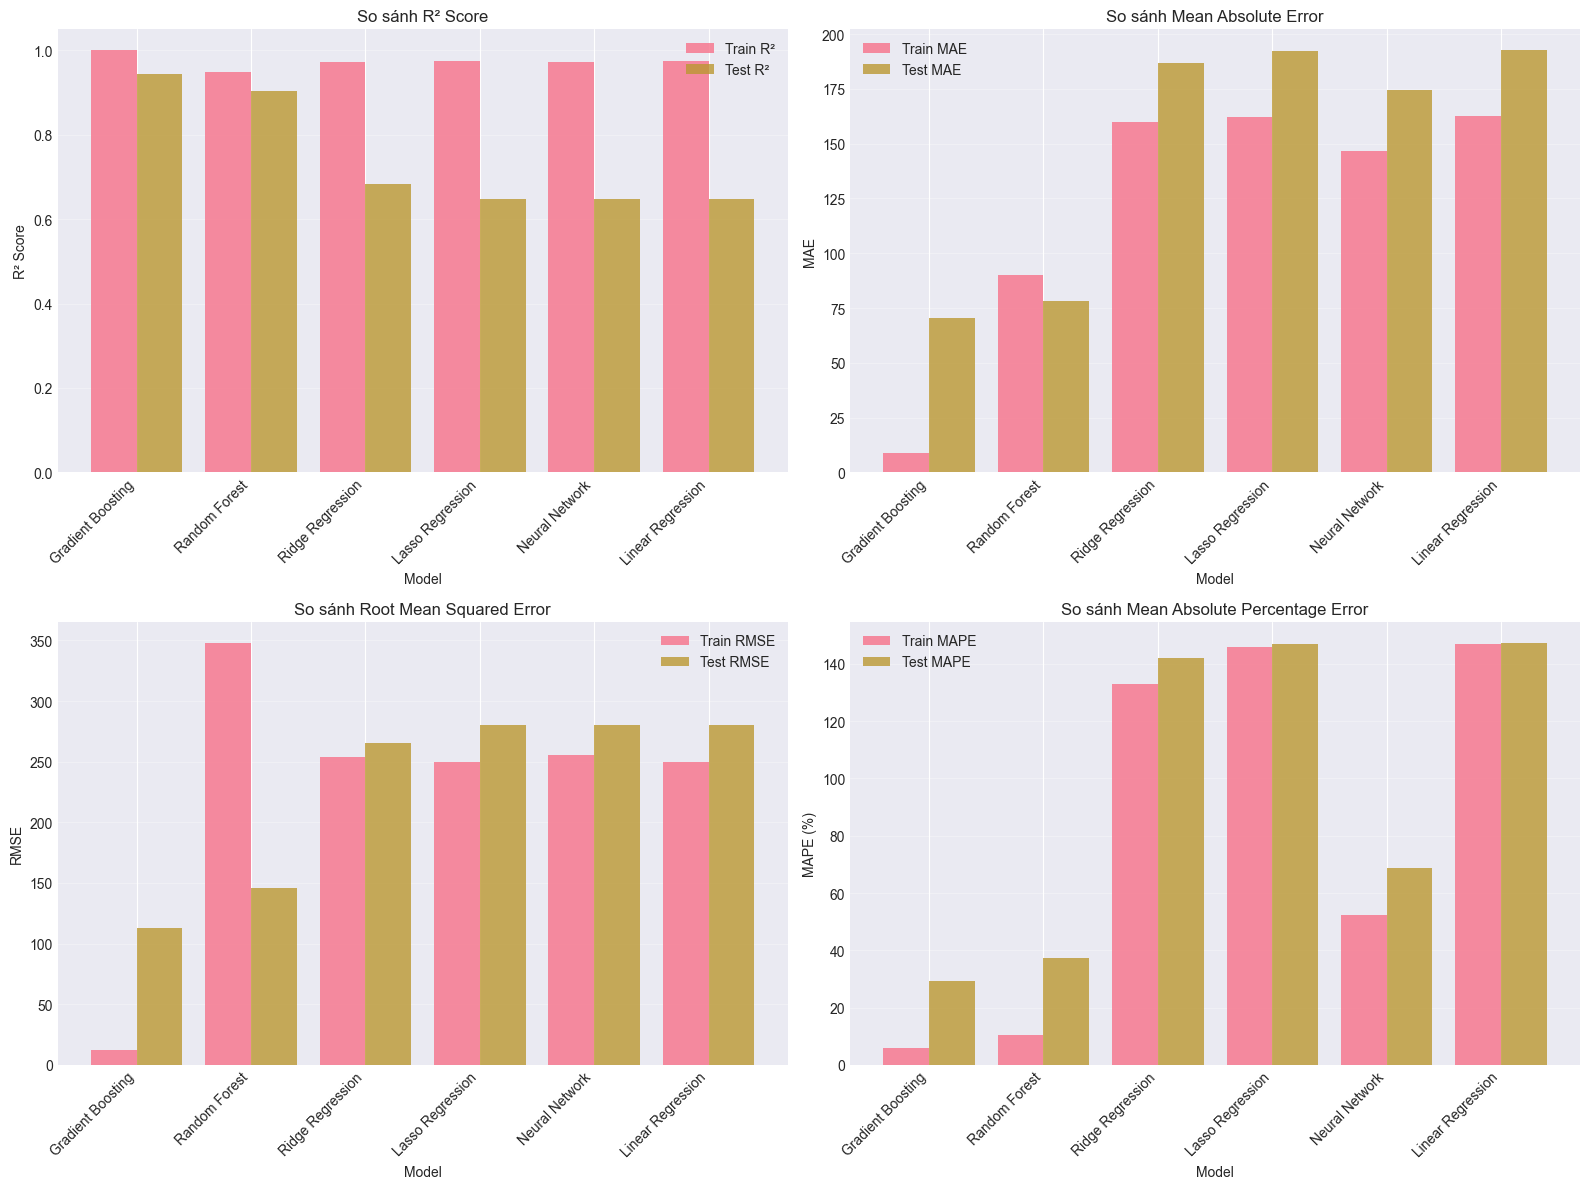


Mô hình tốt nhất: Gradient Boosting
Test R²: 0.9430
Test MAE: 70.3919
Test MAPE: 29.28%


In [53]:
# Tạo DataFrame so sánh kết quả
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train R²': [results[m]['train_r2'] for m in results],
    'Test R²': [results[m]['test_r2'] for m in results],
    'Train MAE': [results[m]['train_mae'] for m in results],
    'Test MAE': [results[m]['test_mae'] for m in results],
    'Train RMSE': [results[m]['train_rmse'] for m in results],
    'Test RMSE': [results[m]['test_rmse'] for m in results],
    'Train MAPE': [results[m]['train_mape'] for m in results],
    'Test MAPE': [results[m]['test_mape'] for m in results],
    'CV MAE': [results[m]['cv_mae'] for m in results]
})

# Sắp xếp theo Test R² giảm dần
comparison_df = comparison_df.sort_values('Test R²', ascending=False)

print("Bảng so sánh kết quả:")
print(comparison_df.to_string(index=False))

# Trực quan hóa kết quả
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. So sánh R² Score
x_pos = np.arange(len(comparison_df))
axes[0, 0].bar(x_pos - 0.2, comparison_df['Train R²'], 0.4, label='Train R²', alpha=0.8)
axes[0, 0].bar(x_pos + 0.2, comparison_df['Test R²'], 0.4, label='Test R²', alpha=0.8)
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('So sánh R² Score')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. So sánh MAE
axes[0, 1].bar(x_pos - 0.2, comparison_df['Train MAE'], 0.4, label='Train MAE', alpha=0.8)
axes[0, 1].bar(x_pos + 0.2, comparison_df['Test MAE'], 0.4, label='Test MAE', alpha=0.8)
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_title('So sánh Mean Absolute Error')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. So sánh RMSE
axes[1, 0].bar(x_pos - 0.2, comparison_df['Train RMSE'], 0.4, label='Train RMSE', alpha=0.8)
axes[1, 0].bar(x_pos + 0.2, comparison_df['Test RMSE'], 0.4, label='Test RMSE', alpha=0.8)
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('RMSE')
axes[1, 0].set_title('So sánh Root Mean Squared Error')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. So sánh MAPE
axes[1, 1].bar(x_pos - 0.2, comparison_df['Train MAPE'], 0.4, label='Train MAPE', alpha=0.8)
axes[1, 1].bar(x_pos + 0.2, comparison_df['Test MAPE'], 0.4, label='Test MAPE', alpha=0.8)
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('MAPE (%)')
axes[1, 1].set_title('So sánh Mean Absolute Percentage Error')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm mô hình tốt nhất
best_model_name = comparison_df.iloc[0]['Model']
print(f"\nMô hình tốt nhất: {best_model_name}")
print(f"Test R²: {comparison_df.iloc[0]['Test R²']:.4f}")
print(f"Test MAE: {comparison_df.iloc[0]['Test MAE']:.4f}")
print(f"Test MAPE: {comparison_df.iloc[0]['Test MAPE']:.2f}%")

## 8. Phân Tích Mô Hình Tốt Nhất

Phân tích chi tiết mô hình tốt nhất: độ chính xác dự đoán và feature importance.

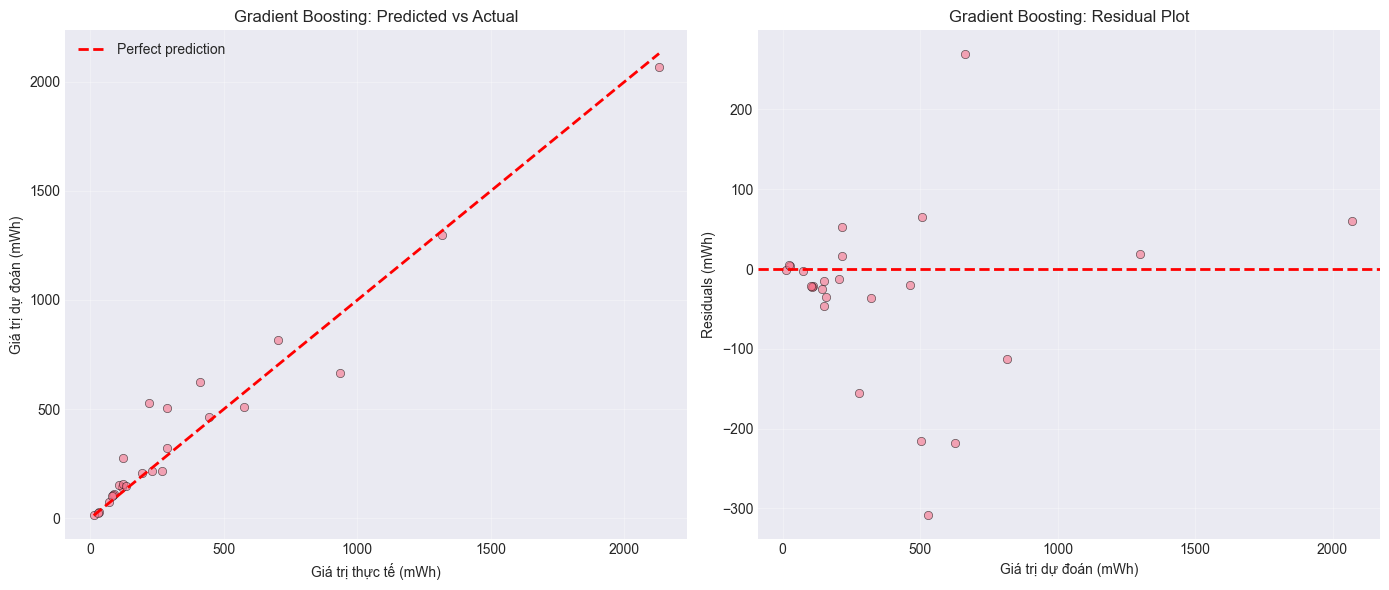


Feature Importance (Gradient Boosting):
                 Feature  Importance
        efficiency_score    0.658042
           latency_avg_s    0.122354
   throughput_iter_per_s    0.064917
latency_throughput_ratio    0.063915
       compute_intensity    0.035395
        gflops_per_param    0.027764
            gmacs_per_mb    0.014486
         energy_per_iter    0.004432
                params_m    0.003112
           params_per_mb    0.001807
                 size_mb    0.001623
        model_complexity    0.001167
                  gflops    0.000626
                   gmacs    0.000361


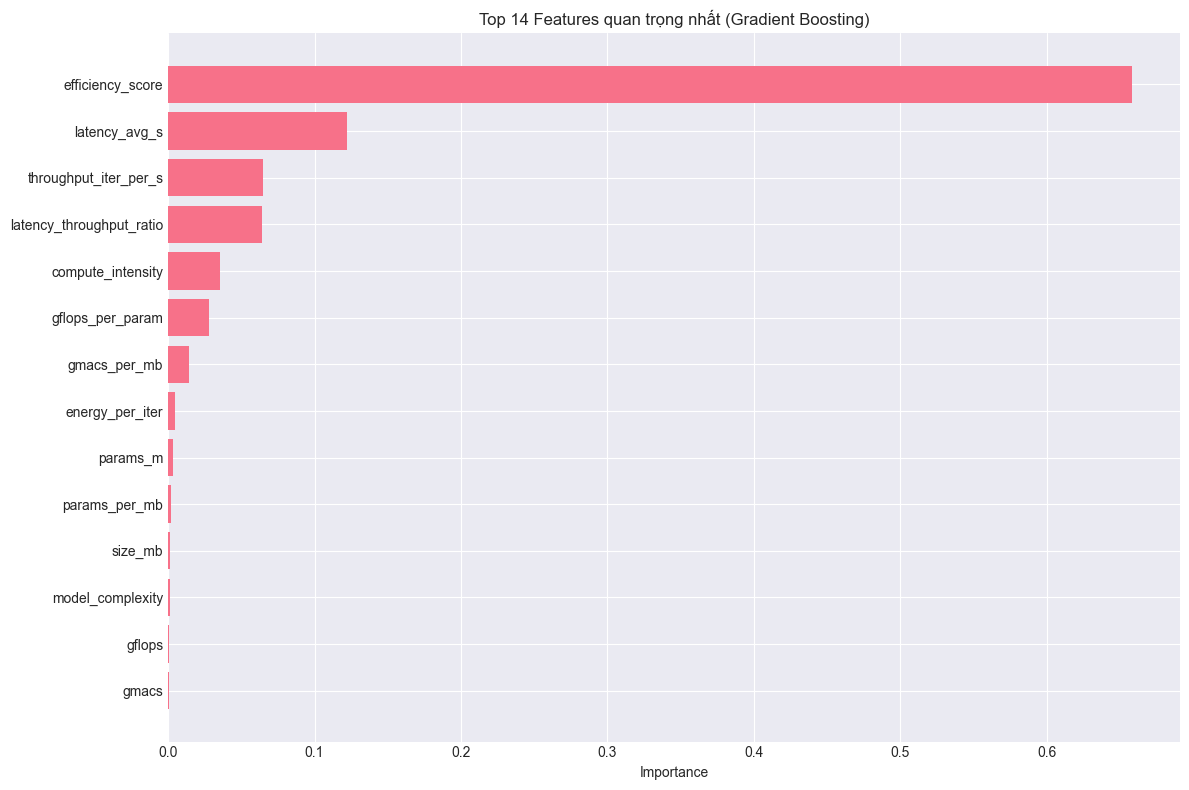

In [54]:
# Lấy mô hình tốt nhất
best_model = results[best_model_name]['model']

# Dự đoán trên tập test
y_pred = best_model.predict(X_test_scaled)

# Vẽ biểu đồ Predicted vs Actual
plt.figure(figsize=(14, 6))

# 1. Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
plt.xlabel('Giá trị thực tế (mWh)')
plt.ylabel('Giá trị dự đoán (mWh)')
plt.title(f'{best_model_name}: Predicted vs Actual')
plt.legend()
plt.grid(alpha=0.3)

# 2. Residual plot
plt.subplot(1, 2, 2)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Giá trị dự đoán (mWh)')
plt.ylabel('Residuals (mWh)')
plt.title(f'{best_model_name}: Residual Plot')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance (nếu mô hình hỗ trợ)
if hasattr(best_model, 'feature_importances_'):
    # Tree-based models
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\nFeature Importance ({best_model_name}):")
    print(feature_importance.to_string(index=False))
    
    # Vẽ biểu đồ feature importance
    plt.figure(figsize=(12, 8))
    top_n = min(15, len(feature_importance))
    plt.barh(range(top_n), feature_importance['Importance'][:top_n])
    plt.yticks(range(top_n), feature_importance['Feature'][:top_n])
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Features quan trọng nhất ({best_model_name})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
elif hasattr(best_model, 'coef_'):
    # Linear models
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Coefficient': np.abs(best_model.coef_)
    }).sort_values('Coefficient', ascending=False)
    
    print(f"\nFeature Coefficients ({best_model_name}):")
    print(feature_importance.to_string(index=False))
    
    # Vẽ biểu đồ coefficients
    plt.figure(figsize=(12, 8))
    top_n = min(15, len(feature_importance))
    plt.barh(range(top_n), feature_importance['Coefficient'][:top_n])
    plt.yticks(range(top_n), feature_importance['Feature'][:top_n])
    plt.xlabel('Absolute Coefficient')
    plt.title(f'Top {top_n} Features quan trọng nhất ({best_model_name})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print(f"\nMô hình {best_model_name} không hỗ trợ feature importance.")

## 9. Lưu Mô Hình

Lưu mô hình tốt nhất, scaler và danh sách features để sử dụng trong hệ thống production.

In [55]:
import os

# Tạo thư mục lưu models nếu chưa tồn tại
model_dir = r'../artifacts'
os.makedirs(model_dir, exist_ok=True)

# Lưu mô hình tốt nhất
model_path = os.path.join(model_dir, 'energy_predictor.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"Đã lưu mô hình tại: {model_path}")

# Lưu scaler
scaler_path = os.path.join(model_dir, 'energy_scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Đã lưu scaler tại: {scaler_path}")

# Lưu danh sách features
features_path = os.path.join(model_dir, 'feature_names.pkl')
with open(features_path, 'wb') as f:
    pickle.dump(feature_columns, f)
print(f"Đã lưu danh sách features tại: {features_path}")

# Lưu thông tin mô hình
model_info = {
    'model_name': best_model_name,
    'test_r2': comparison_df.iloc[0]['Test R²'],
    'test_mae': comparison_df.iloc[0]['Test MAE'],
    'test_rmse': comparison_df.iloc[0]['Test RMSE'],
    'test_mape': comparison_df.iloc[0]['Test MAPE'],
    'cv_mae': comparison_df.iloc[0]['CV MAE'],
    'n_features': len(feature_columns),
    'n_samples': len(df)
}

info_path = os.path.join(model_dir, 'model_info.pkl')
with open(info_path, 'wb') as f:
    pickle.dump(model_info, f)
print(f"Đã lưu thông tin mô hình tại: {info_path}")

print("\n" + "="*80)
print("Hoàn thành! Các file đã được lưu:")
print(f"  1. Mô hình: energy_predictor.pkl")
print(f"  2. Scaler: energy_scaler.pkl")
print(f"  3. Features: feature_names.pkl")
print(f"  4. Thông tin: model_info.pkl")
print("="*80)

Đã lưu mô hình tại: D:\DACN\ml-controller\energy_predictor.pkl
Đã lưu scaler tại: D:\DACN\ml-controller\energy_scaler.pkl
Đã lưu danh sách features tại: D:\DACN\ml-controller\feature_names.pkl
Đã lưu thông tin mô hình tại: D:\DACN\ml-controller\model_info.pkl

Hoàn thành! Các file đã được lưu:
  1. Mô hình: energy_predictor.pkl
  2. Scaler: energy_scaler.pkl
  3. Features: feature_names.pkl
  4. Thông tin: model_info.pkl


## 10. Tổng Kết

Notebook này đã hoàn thành việc xây dựng và đánh giá mô hình dự đoán năng lượng tiêu thụ cho các mô hình ML.

**Các bước đã thực hiện:**
1. Import thư viện và load dataset (126 mô hình)
2. Phân tích khám phá dữ liệu (EDA)
3. Tạo 8 features mới từ các features hiện có
4. Chuẩn bị dữ liệu (train/test split, scaling)
5. Huấn luyện 6 thuật toán ML khác nhau
6. So sánh và chọn mô hình tốt nhất
7. Phân tích chi tiết mô hình tốt nhất
8. Lưu mô hình và các file cần thiết

**Các bước tiếp theo:**
- Tích hợp mô hình vào hệ thống ML Controller
- Thêm API endpoint /predict-energy
- Cập nhật dashboard hiển thị dự đoán năng lượng
- Test với các mô hình mới trong thực tế

## 11. Compute Additional Evaluation Metrics

**Mục đích:** Tính toán các metrics bổ sung theo yêu cầu đề tài

**Metrics:**
- RMSE (Root Mean Square Error)
- Spearman Correlation
- Kendall Tau Correlation
- Energy-Delay Product (EDP)
- Performance per Watt

In [ ]:
# Import thêm các thư viện cần thiết
from scipy.stats import spearmanr, kendalltau
from sklearn.metrics import mean_squared_error

print("=" * 80)
print("ADDITIONAL EVALUATION METRICS")
print("=" * 80)

# Giả định best_model_name đã được định nghĩa ở cell trước
# Nếu chưa, uncomment dòng dưới:
# best_model_name = 'Gradient Boosting'

# Load lại model và data nếu cần
# Giả định các biến y_test_scaled, y_pred_best_scaled đã có
# Nếu chưa có, cần load lại từ artifacts hoặc rerun training cells

# 1. RMSE (Root Mean Square Error)
rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred_best_scaled))

# 2. Spearman Correlation
# Đo correlation giữa ranking của predicted và actual values
spearman_corr, spearman_pvalue = spearmanr(y_test_scaled, y_pred_best_scaled)

# 3. Kendall Tau Correlation  
# Đo concordance giữa ordering của predicted và actual
kendall_tau, kendall_pvalue = kendalltau(y_test_scaled, y_pred_best_scaled)

# 4. Energy-Delay Product (EDP)
# EDP = Energy × Latency (lower is better)
# Tính trung bình EDP từ test set
df_test_with_pred = df_clean.loc[y_test_scaled.index].copy()
df_test_with_pred['energy_pred'] = y_pred_best_scaled
df_test_with_pred['edp_actual'] = df_test_with_pred['energy_avg_mwh'] * df_test_with_pred['latency_avg_s']
df_test_with_pred['edp_predicted'] = df_test_with_pred['energy_pred'] * df_test_with_pred['latency_avg_s']

mean_edp_actual = df_test_with_pred['edp_actual'].mean()
mean_edp_predicted = df_test_with_pred['edp_predicted'].mean()
edp_mae = mean_absolute_error(df_test_with_pred['edp_actual'], df_test_with_pred['edp_predicted'])

# 5. Performance per Watt
# Performance = Throughput (iterations/s)
# Performance per Watt = Throughput / Power (W)
# Chuyển mWh sang W: Power (W) = Energy (mWh) / Time(h)
# Giả định inference time ~ latency
df_test_with_pred['power_actual_w'] = df_test_with_pred['energy_avg_mwh'] / (df_test_with_pred['latency_avg_s'] / 3600) / 1000
df_test_with_pred['power_pred_w'] = df_test_with_pred['energy_pred'] / (df_test_with_pred['latency_avg_s'] / 3600) / 1000
df_test_with_pred['perf_per_watt_actual'] = df_test_with_pred['throughput_iter_per_s'] / df_test_with_pred['power_actual_w']
df_test_with_pred['perf_per_watt_pred'] = df_test_with_pred['throughput_iter_per_s'] / df_test_with_pred['power_pred_w']

mean_ppw_actual = df_test_with_pred['perf_per_watt_actual'].mean()
mean_ppw_predicted = df_test_with_pred['perf_per_watt_pred'].mean()
ppw_mae = mean_absolute_error(df_test_with_pred['perf_per_watt_actual'], df_test_with_pred['perf_per_watt_pred'])

# Display Results
print(f"\n📊 Model: {best_model_name}")
print("=" * 80)

print("\n1️⃣ RMSE (Root Mean Square Error)")
print(f"   RMSE: {rmse:.4f} mWh")
print(f"   Note: RMSE penalizes larger errors more than MAE")
print(f"   Comparison: MAE = {best_mae:.2f} mWh, RMSE = {rmse:.4f} mWh")

print("\n2️⃣ Spearman Rank Correlation")
print(f"   Spearman ρ: {spearman_corr:.6f}")
print(f"   P-value: {spearman_pvalue:.2e}")
print(f"   Interpretation: {'Excellent' if spearman_corr > 0.9 else 'Good' if spearman_corr > 0.7 else 'Moderate'} ranking correlation")
print(f"   Note: Measures monotonic relationship (order preservation)")

print("\n3️⃣ Kendall Tau Correlation")
print(f"   Kendall τ: {kendall_tau:.6f}")
print(f"   P-value: {kendall_pvalue:.2e}")
print(f"   Interpretation: {'Excellent' if kendall_tau > 0.8 else 'Good' if kendall_tau > 0.6 else 'Moderate'} concordance")
print(f"   Note: Robust to outliers, measures pairwise concordance")

print("\n4️⃣ Energy-Delay Product (EDP)")
print(f"   Mean EDP (Actual): {mean_edp_actual:.6f} mWh·s")
print(f"   Mean EDP (Predicted): {mean_edp_predicted:.6f} mWh·s")
print(f"   EDP MAE: {edp_mae:.6f} mWh·s")
print(f"   Note: EDP = Energy × Latency (lower is better for efficiency)")

print("\n5️⃣ Performance per Watt")
print(f"   Mean Perf/Watt (Actual): {mean_ppw_actual:.2f} iter/s/W")
print(f"   Mean Perf/Watt (Predicted): {mean_ppw_predicted:.2f} iter/s/W")
print(f"   Perf/Watt MAE: {ppw_mae:.2f} iter/s/W")
print(f"   Note: Higher is better - measures computational efficiency")

print("\n" + "=" * 80)
print("SUMMARY OF ALL METRICS")
print("=" * 80)
print(f"R² Score:              {best_r2:.6f}")
print(f"MAE (Mean Abs Error):  {best_mae:.2f} mWh")
print(f"MAPE (Mean Abs % Err): {best_mape:.2f}%")
print(f"RMSE:                  {rmse:.4f} mWh")
print(f"Spearman Correlation:  {spearman_corr:.6f}")
print(f"Kendall Tau:           {kendall_tau:.6f}")
print(f"EDP MAE:               {edp_mae:.6f} mWh·s")
print(f"Perf/Watt MAE:         {ppw_mae:.2f} iter/s/W")
print("=" * 80)

print("\n✅ All additional metrics computed successfully!")